In [1]:
import pandas as pd
import numpy as np
import scipy
from pykalman.pykalman import *
import control

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', font_scale=1.5)
from statannotations.Annotator import Annotator
import statsmodels.formula.api as smf
import statsmodels as stats

import prep_emotioncon 
import emotioncon_modelling
import emotioncon_stats
import auxiliary

In [2]:
emo = emotioncon_modelling.Modelling()
emostats = emotioncon_stats.Statistics()
prep = prep_emotioncon.PrepEmotioncon()
aux = auxiliary.Auxiliary()
attention_cr = np.array([1, 0, 0, 1, 1, 1, 1, 0, 0, 0])
mood_categories = ['disgusted', 'amused', 'calm', 'anxious', 'sad']
filepath = '../'
data = np.load(filepath + 'results/data_experiment.npy',allow_pickle='TRUE')
savefig = True
palette= {0: "plum", 1: "purple", 2: "lightgrey", 3: "grey"}

In [3]:
# make inputs ready
input_df = pd.read_csv(filepath + 'experiment/public/prep/videosForExperiment.csv')
inp_dummies = pd.get_dummies(input_df['category'])
inp_dummies = inp_dummies.reindex(columns=['Disgust', 'Amusement', 'Calmness', 'Anxiety', 'Sadness'])
inp = inp_dummies.values
inp = np.vstack([np.zeros(np.shape(inp)[1]), inp, np.zeros(np.shape(inp)[1]), inp])

In [4]:
data = np.load(filepath + 'results/fit_experiment.npy',allow_pickle='TRUE')
df, mood_ratings, foo = prep.create_df_from_dict(data)
dynamics, controls = prep.rearrange_data_for_stats(data)
Nsj = len(data)
print('N = ' + str(Nsj))

N = 108


/Users/jolandamalamud/phd/papers/git/emotioncon_public/analyses/prep_emotioncon.py:119: RuntimeWarning: invalid value encountered in log
  dynamics['HL'][:,sj,k] = np.log(0.5) / np.log(e)


In [5]:
# outlier Detection (IQR)
def detect_outlier(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    ex = np.where((data >= (Q1-1.5*IQR))&(data >= (Q3+1.5*IQR)))[0]
    print(Q1-1.5*IQR, Q3+1.5*IQR)
    return ex

/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


(-0.20278586109784763+0j) (1.4376784614085574+0j)
dynamics outliers: []
(-519.8066256074557+0j) (1263.539578100499+0j)
controllability outliers: [18 40]


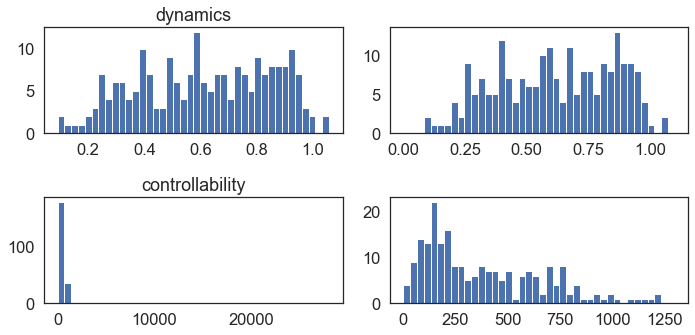

In [6]:
fig,ax = plt.subplots(2,2,figsize=(10,5))
cut = [1.1, 1300]
label = ['dynamics', 'controllability']
for j, i in enumerate([dynamics['val'][0,:,:], controls['val'][0,:,:]]):
    ax[j, 0].hist(i.flatten(), 40);
    ax[j, 0].set(title=label[j])
    ax[j, 1].hist(i.flatten(), 40, range=(0,cut[j]));
    print(label[j] + ' outliers: ' + str(detect_outlier(i)))
fig.tight_layout()

In [7]:
# outlier detection based on singular values in controllability matrix
ex = detect_outlier(controls['val'][0,:,:])

(-519.8066256074557+0j) (1263.539578100499+0j)


group: 1.0


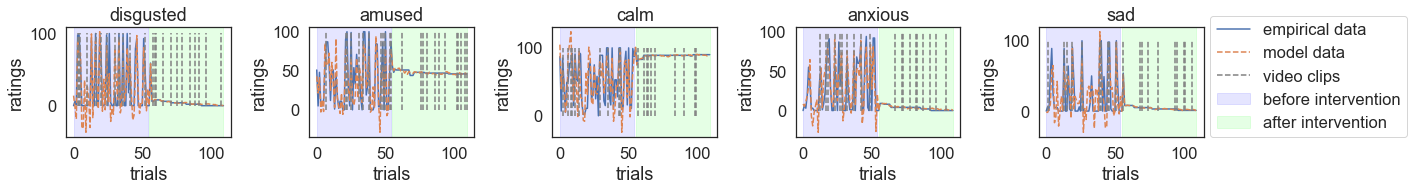

group: 1.0


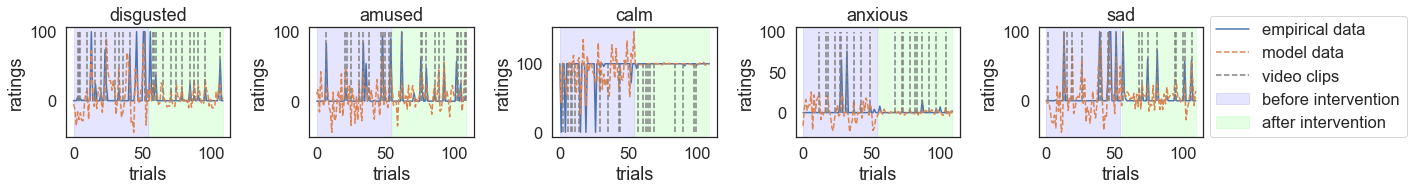

In [8]:
# excluded case
T = np.shape(data[0]['ratings'])[1]
for sj in ex:
    print('group: ' + str(df['randomized_condition'][sj]))
    fig, axs = plt.subplots(1,len(mood_categories),figsize=[20,3])
    x = np.empty((T,5))
    for t in range(2):
        inp_split = inp[t*int(T/2):t*int(T/2) + int(T/2),:]
        z, x[t*int(T/2):t*int(T/2) + int(T/2),:] = \
        data[sj]['results_split'][13+t].sample(int(T/2),  initial_state=data[sj]['ratings'][:,t*int(T/2)], \
                                                control_inputs=inp_split)
        
    for k in range(len(mood_categories)):
        axs[k].plot(mood_ratings[:,k,sj]);
        axs[k].plot(x[:,k], linestyle='--');
        axs[k].set_title(mood_categories[k]);
        axs[k].set_ylabel('ratings');
        axs[k].set_xlabel('trials');
        axs[k].vlines(np.where(inp[:,k]), ymin=0, ymax=100, color='gray', linestyles = 'dashed')
        ylim = axs[k].get_ylim()
        axs[k].add_patch(plt.Rectangle((0, ylim[0]), 54, np.abs(ylim[0]) + ylim[1], edgecolor=(0, 0, 1, 0.1), facecolor=(0, 0, 1, 0.1)))
        axs[k].add_patch(plt.Rectangle((55, ylim[0]), 54, np.abs(ylim[0]) + ylim[1], edgecolor=(0, 1, 0, 0.1), facecolor=(0, 1, 0, 0.1)))
    plt.legend(['empirical data','model data', 'video clips','before intervention', 'after intervention'], loc=(1.04,0))
    plt.tight_layout()
    plt.show()

In [9]:
# exclude outliers due to fit
data = np.delete(data,ex)
Nsj = len(data)
print('N = ' + str(Nsj))
np.save(filepath + 'results/fit_experiment_included.npy', data)
df, mood_ratings, foo = prep.create_df_from_dict(data)
dynamics, controls = prep.rearrange_data_for_stats(data)
print('number in distancing group: ' + str(df['randomized_condition'].sum()))

N = 106
number in distancing group: 55.0


/Users/jolandamalamud/phd/papers/git/emotioncon_public/analyses/prep_emotioncon.py:119: RuntimeWarning: invalid value encountered in log
  dynamics['HL'][:,sj,k] = np.log(0.5) / np.log(e)


In [10]:
# norm of matrices as a measure of overall extrnal control or controllability
for d in [controls['matrix'], 'gramian']:
    for t in range(2):
        cc=[]
        for i in range(Nsj):
            if d == 'gramian': c = control.ctrb(dynamics['matrix'][:,:,i,t],controls['matrix'][:,:,i,t])
            else: c = d[:,:,i,t]
            cc.append(np.linalg.norm(c))
        for i in range(2):
            print('Gramian-norm group ' + str(i) + ': ' \
                  + str(np.round(np.nanmean(np.array(cc)[df['randomized_condition']==i]))) \
                  + '±' + str(np.round(np.nanstd(np.array(cc)[df['randomized_condition']==i]))))
        print(scipy.stats.mannwhitneyu(np.array(cc)[df['randomized_condition']==0],\
                                       np.array(cc)[df['randomized_condition']==1]))

Gramian-norm group 0: 347.0±204.0
Gramian-norm group 1: 278.0±183.0
MannwhitneyuResult(statistic=1690.0, pvalue=0.06956401223763509)
Gramian-norm group 0: 396.0±221.0
Gramian-norm group 1: 253.0±217.0
MannwhitneyuResult(statistic=1972.0, pvalue=0.0003208430887935898)
Gramian-norm group 0: 447.0±292.0
Gramian-norm group 1: 347.0±233.0
MannwhitneyuResult(statistic=1669.0, pvalue=0.09257789239282957)
Gramian-norm group 0: 504.0±292.0
Gramian-norm group 1: 332.0±283.0
MannwhitneyuResult(statistic=1921.0, pvalue=0.001055188950464923)


/var/folders/5z/t44r3krd25sftrcjrj8j__4m0000gn/T/ipykernel_87840/580328917.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if d == 'gramian': c = control.ctrb(dynamics['matrix'][:,:,i,t],controls['matrix'][:,:,i,t])
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/control/statesp.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)


statistics done using absolute value of eigenvectors!
--

In [11]:
label = ['stability', 'controllability']
# before intervention measures should be similar for distancing and control condition
for k,p in enumerate([dynamics, controls]):
    print(20*'#' + '\n' + label[k] + ':')
    mm = []
    print('eigenvectors')
    for i in range(2):
        mm.append(np.nanmedian(p['absvec'][:,0,df['randomized_condition']==i,0],axis=1))
        mm.append(np.nanstd(p['absvec'][:,0,df['randomized_condition']==i,0],axis=1))
    df_new = pd.DataFrame(mm).T
    df_new.columns = ['mean control', 'std control', 'mean distancing', 'std distancing']
    df_new.index = mood_categories
    display(df_new)

    mm = []
    print('eigenvalues')
    for i in range(2):
        mm.append(np.real(np.nanmedian(p['val'][:,df['randomized_condition']==i,0],axis=1)))
        mm.append(np.real(np.nanstd(p['val'][:,df['randomized_condition']==i,0],axis=1)))
    df_new = pd.DataFrame(mm).T
    df_new.columns = ['mean control', 'std control', 'mean distancing', 'std distancing']
    df_new.index = [[str(i+1) + '.' for i in range(5)]]
    display(df_new)

####################
stability:
eigenvectors


,mean control,std control,mean distancing,std distancing
disgusted,0.279301,0.219354,0.361218,0.224104
amused,0.284062,0.206424,0.197434,0.232655
calm,0.411229,0.256760,0.503789,0.269793
anxious,0.450201,0.207521,0.401291,0.248536
sad,0.331696,0.192683,0.279832,0.228246


eigenvalues


,mean control,std control,mean distancing,std distancing
1.,0.577092,0.223776,0.655489,0.217781
2.,0.341017,0.209628,0.387018,0.242463
3.,0.156142,0.216202,0.237759,0.253481
4.,0.027559,0.180009,0.047767,0.215908
5.,-0.104394,0.229357,-0.064874,0.194945


####################
controllability:
eigenvectors


,mean control,std control,mean distancing,std distancing
disgusted,0.524728,0.239720,0.471289,0.227173
amused,0.348443,0.212322,0.323472,0.206196
calm,0.360075,0.201585,0.411582,0.217928
anxious,0.439573,0.203717,0.342741,0.231895
sad,0.354090,0.181952,0.387936,0.198430


eigenvalues


,mean control,std control,mean distancing,std distancing
1.,360.979105,297.605100,274.469190,237.407576
2.,99.807291,35.233707,84.586062,41.916910
3.,56.983189,18.595555,47.247064,21.348022
4.,35.148061,15.974876,27.067399,14.884524
5.,18.952811,13.890020,13.839164,12.511826


stability


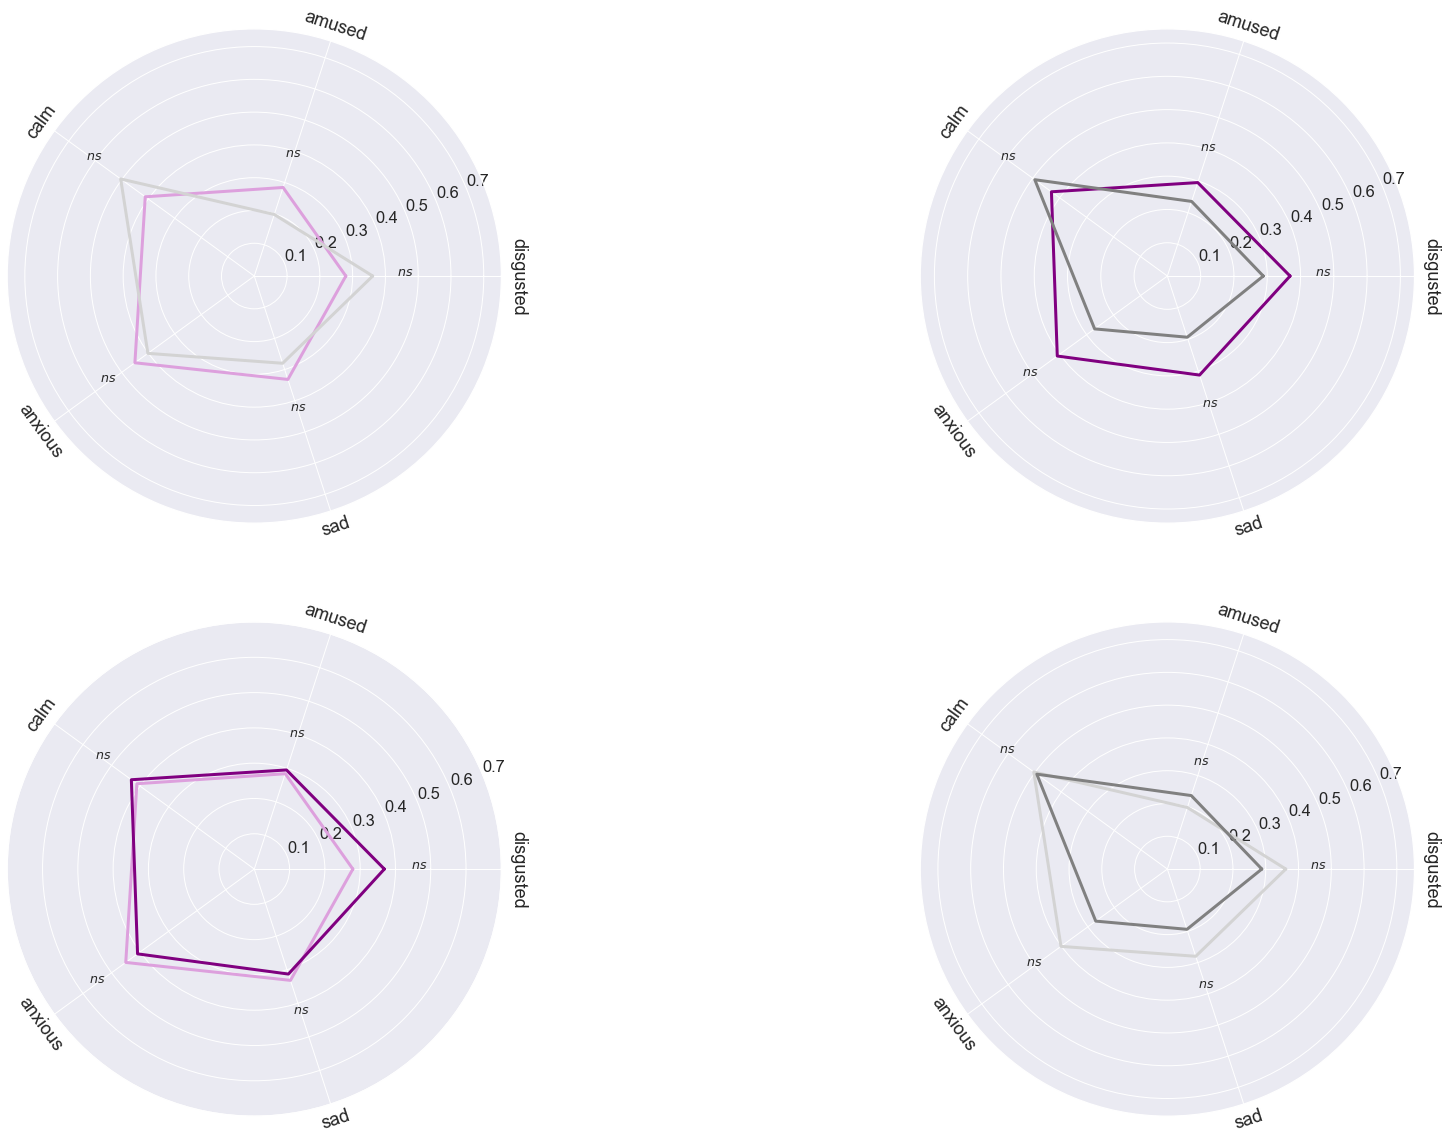

controllability


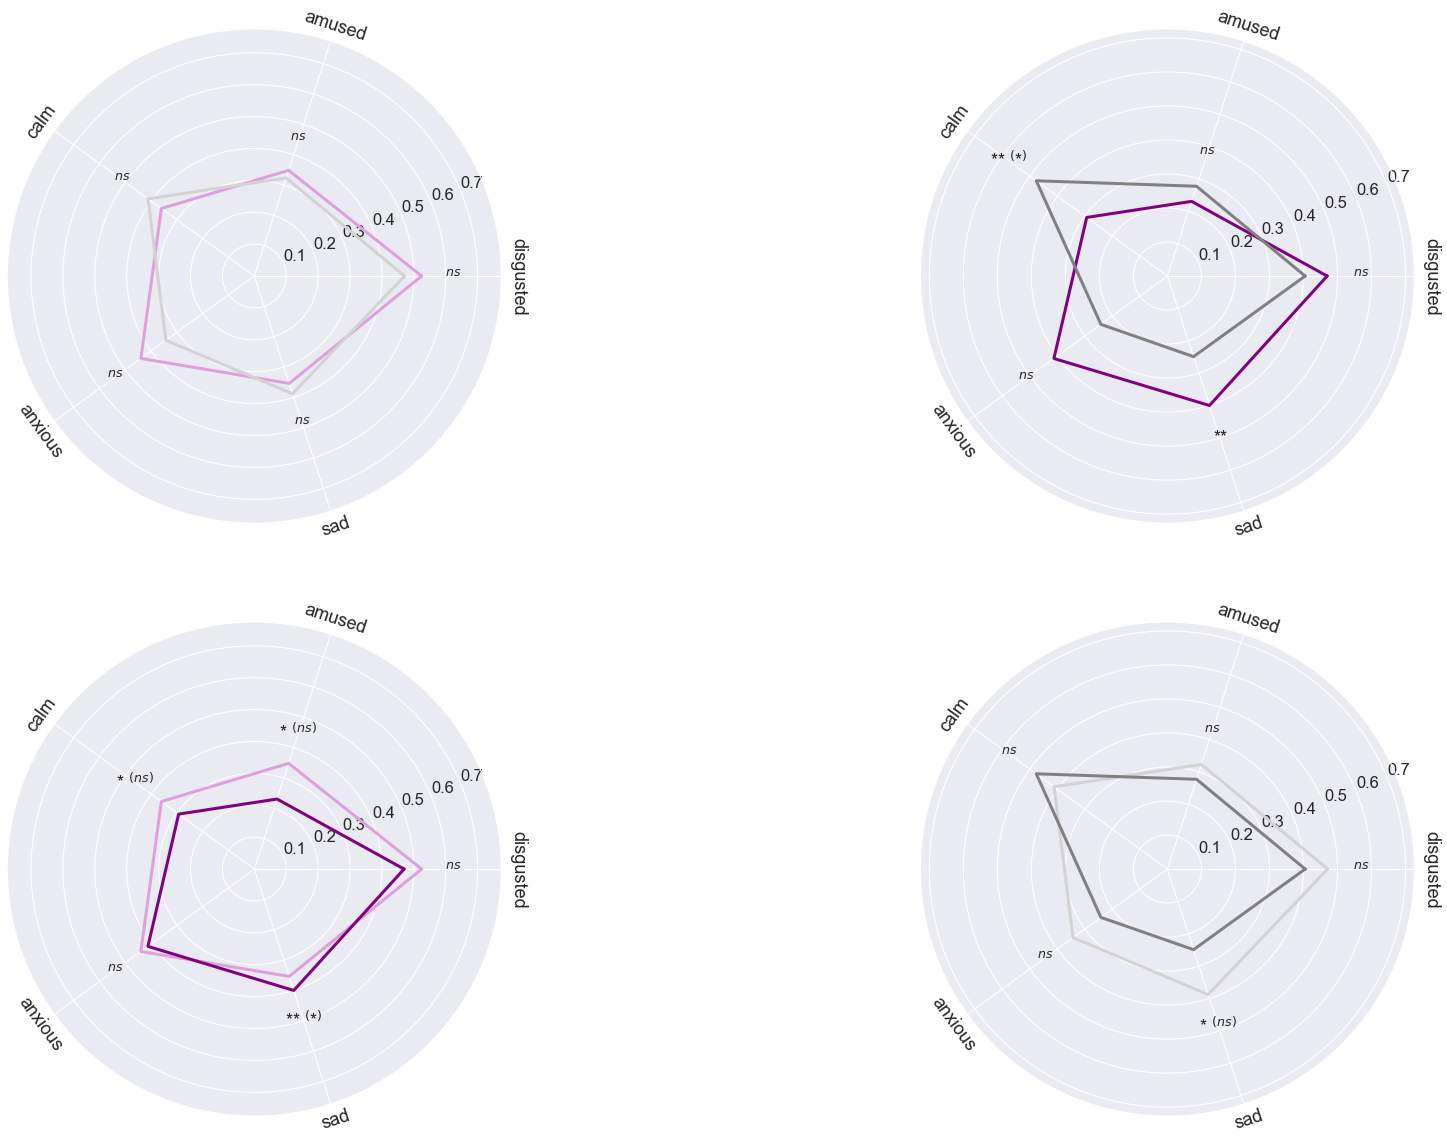

In [12]:
sns.set(font_scale=1.5)
data_label=['stability', 'controllability']
for j, d in enumerate([dynamics, controls]):
    print(data_label[j])
    plot_data = d['absvec'][:,0,:,:]
    fig = plt.figure(figsize=(30, 20))
    ax = plt.subplot(2,2,1, polar=True)
    palette= {0: "plum", 1: "purple", 2: "lightgrey", 3: "grey"}
    medians = np.full((len(mood_categories)+1, 4), np.nan)
    pvalues = np.full((len(mood_categories), 4), np.nan)
    x = np.linspace(0, 2 * np.pi, len(mood_categories)+1)
    for i in range(2):
        for m in range(5):
            pvalues[m,i] = scipy.stats.wilcoxon(plot_data[m,df['randomized_condition']==i,0].T, \
                                                    plot_data[m,df['randomized_condition']==i,1].T).pvalue
            pvalues[m,i] = stats.stats.multitest.multipletests(pvalues[m,i], method='bonferroni')[1]
        for t in range(2):
            tmp = np.nanmedian(plot_data[:,df['randomized_condition']==i,t],axis=1)
            medians[:,t + (i*2)] = np.append(tmp, tmp[0])
            pvalues[:,2+t] = scipy.stats.mannwhitneyu(plot_data[:,df['randomized_condition']==0,t].T, \
                                                plot_data[:,df['randomized_condition']==1,t].T).pvalue
            pvalues[:,2+t] = stats.stats.multitest.multipletests(pvalues[:,2+t], method='bonferroni')[1]

    aux.polar_plot(medians[:,[0,2]], mood_categories, [palette[0], palette[2]], \
               ax, plt, pval=list(pvalues[:,2]))

    ax = plt.subplot(2,2,2, polar=True)
    aux.polar_plot(medians[:,[1,3]], mood_categories, [palette[1], palette[3]], \
               ax, plt, pval=list(pvalues[:,3]))
    ax = plt.subplot(2,2,3, polar=True)
    aux.polar_plot(medians[:,[0,1]], mood_categories, [palette[0], palette[1]], \
               ax, plt, pval=list(pvalues[:,0]))
    ax = plt.subplot(2,2,4, polar=True)
    aux.polar_plot(medians[:,[2,3]], mood_categories, [palette[2], palette[3]], \
               ax, plt, pval=list(pvalues[:,1]))
    plt.show()
#     plt.savefig('/Users/jolandamalamud/Desktop/' + data_label[j] + '_eigenvector.png', bbox_inches='tight')

[[-0.482  1.223 -1.279  1.219  1.002  0.361  1.519 -2.874  1.344  1.852]
 [ 0.631  0.224  0.204  0.225  0.319  0.719  0.132  0.005  0.182  0.067]]
[[ 0.245  0.047 -0.942  1.551 -0.548  1.798 -0.749 -3.714  1.448  3.605]
 [ 0.807  0.962  0.349  0.124  0.585  0.075  0.455  0.     0.151  0.   ]]


,T2,Fstats,pvalue,T2,Fstats,pvalue
before intervention,6.71,1.29,0.274,3.64,0.70,0.624
after intervention,14.77,2.84,0.019,23.66,4.55,< 0.001
change (after - before),1.68,0.32,0.898,16.27,3.13,0.011


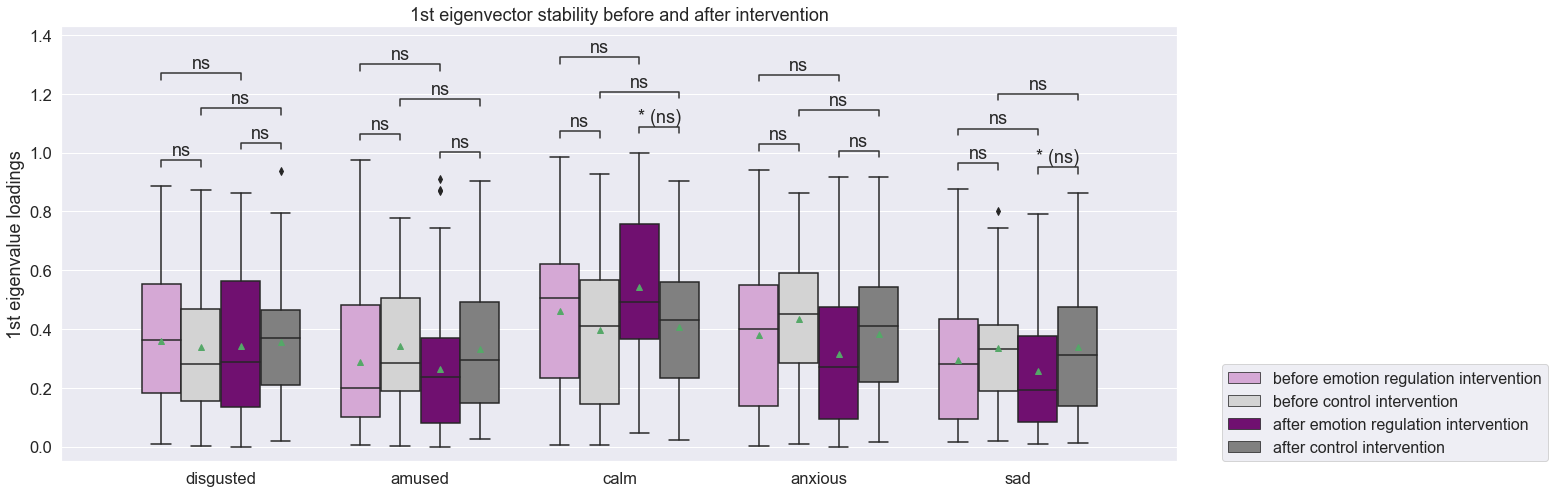

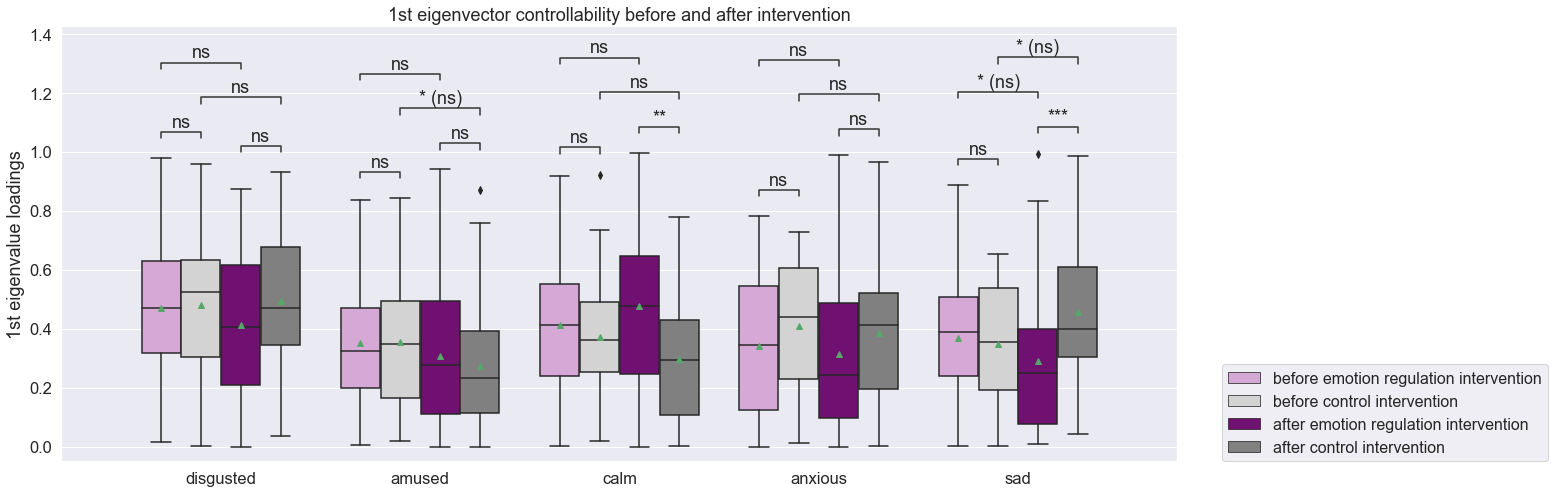

In [13]:
# compare first eigenvector of controllability & stability after intervention
pairs = []
for t in range(2):
    for i in mood_categories:
        pairs.append([(i, 0+t), (i, 2+t)])
        pairs.append([(i, t+(t*1)), (i, t+(t*1)+1)])
        
df_stats_both = pd.DataFrame()
for j, i in enumerate([dynamics, controls]):
    df_stats, pvalues, tvalues = emostats.stats_group_difference(i['absvec'][:,0,:,:], df)
    df_plot = emostats.make_df(i['absvec'][:,0,:,:], df, mood_categories)
    fig, ax = plt.subplots(figsize=(20,8))
    fig, ax = emostats.plot_group_difference(df=df_plot, data_labels=mood_categories, \
                                             data_name='1st eigenvector ' + label[j] , pairs=pairs, fig=fig, ax=ax)
    ax.set(ylabel='1st eigenvalue loadings')
    df_stats_both = pd.concat((df_stats_both, df_stats), axis=1)
    print(np.round([tvalues,pvalues],3))
    if savefig: plt.savefig('/Users/jolandamalamud/Desktop/' + label[j] + 'vec.png', bbox_inches='tight')

display(df_stats_both)
# print(df_stats_both.to_latex())
# import dataframe_image as dfi
# dfi.export(df_stats_both, '/Users/jolandamalamud/Desktop/mean_stats.png')

In [14]:
# check interaction using MANOVA
from statsmodels.multivariate.manova import MANOVA
for j, p in enumerate([dynamics, controls]):
    print(['stability', 'controllability'][j])
    df_test = pd.DataFrame()
    for t in range(2):
        df_test = pd.concat((df_test, pd.DataFrame(p['absvec'][:,0,:,t])),axis=1, \
                            ignore_index=True)
    df_test = df_test.T
    df_test.columns = mood_categories
    df_test['time'] = np.concatenate((np.zeros([Nsj,1]),np.ones([Nsj,1])))
    df_test['condition'] = np.concatenate((df['randomized_condition'].values,df['randomized_condition'].values))
    fit = MANOVA.from_formula('disgusted + amused + calm + anxious + sad ~ condition*time', data=df_test)
    display(fit.mv_test().summary_frame)
    print('single stats using Mann Withney U test:')
    for i in range(5):
        dd = p['absvec'][i,0,:,1]
        print(scipy.stats.mannwhitneyu(dd[df['randomized_condition']==0],dd[df['randomized_condition']==1]))
    print(100*'-')

stability


Value Num DF Den DF     F Value  \
Effect         Statistic                                                     
Intercept      Wilks' lambda            0.072661      5  204.0  520.709018   
               Pillai's trace           0.927339    5.0  204.0  520.709018   
               Hotelling-Lawley trace  12.762476      5  204.0  520.709018   
               Roy's greatest root     12.762476      5    204  520.709018   
condition      Wilks' lambda            0.969625      5  204.0    1.278107   
               Pillai's trace           0.030375    5.0  204.0    1.278107   
               Hotelling-Lawley trace   0.031326      5  204.0    1.278107   
               Roy's greatest root      0.031326      5    204    1.278107   
time           Wilks' lambda            0.992494      5  204.0    0.308545   
               Pillai's trace           0.007506    5.0  204.0    0.308545   
               Hotelling-Lawley trace   0.007562      5  204.0    0.308545   
               Roy's greatest root      0.007562      5    204    0.308545   
condition:time Wilks' lambda            0.993604      5  204.0    0.262646   
               Pillai's trace           0.006396    5.0  204.0    0.262646   
               Hotelling-Lawley trace   0.006437      5  204.0    0.262646   
               Roy's greatest root      0.006437      5    204    0.262646   

                                         Pr > F  
Effect         Statistic                         
Intercept      Wilks' lambda                0.0  
               Pillai's trace               0.0  
               Hotelling-Lawley trace       0.0  
               Roy's greatest root          0.0  
condition      Wilks' lambda           0.274661  
               Pillai's trace          0.274661  
               Hotelling-Lawley trace  0.274661  
               Roy's greatest root     0.274661  
time           Wilks' lambda           0.907443  
               Pillai's trace          0.907443  
               Hotelling-Lawley trace  0.907443  
               Roy's greatest root     0.907443  
condition:time Wilks' lambda           0.933005  
               Pillai's trace          0.933005  
               Hotelling-Lawley trace  0.933005  
               Roy's greatest root     0.933005

single stats using Mann Withney U test:
MannwhitneyuResult(statistic=1510.0, pvalue=0.49867551408618027)
MannwhitneyuResult(statistic=1673.0, pvalue=0.0877763663280076)
MannwhitneyuResult(statistic=1021.0, pvalue=0.01599132009669183)
MannwhitneyuResult(statistic=1654.0, pvalue=0.11248856524930763)
MannwhitneyuResult(statistic=1747.0, pvalue=0.029618302693891194)
----------------------------------------------------------------------------------------------------
controllability


Value Num DF Den DF     F Value  \
Effect         Statistic                                                     
Intercept      Wilks' lambda            0.046478      5  204.0  837.043237   
               Pillai's trace           0.953522    5.0  204.0  837.043237   
               Hotelling-Lawley trace  20.515766      5  204.0  837.043237   
               Roy's greatest root     20.515766      5    204  837.043237   
condition      Wilks' lambda            0.986179      5  204.0    0.571794   
               Pillai's trace           0.013821    5.0  204.0    0.571794   
               Hotelling-Lawley trace   0.014015      5  204.0    0.571794   
               Roy's greatest root      0.014015      5    204    0.571794   
time           Wilks' lambda            0.949409      5  204.0    2.174113   
               Pillai's trace           0.050591    5.0  204.0    2.174113   
               Hotelling-Lawley trace   0.053287      5  204.0    2.174113   
               Roy's greatest root      0.053287      5    204    2.174113   
condition:time Wilks' lambda            0.945328      5  204.0    2.359618   
               Pillai's trace           0.054672    5.0  204.0    2.359618   
               Hotelling-Lawley trace   0.057834      5  204.0    2.359618   
               Roy's greatest root      0.057834      5    204    2.359618   

                                         Pr > F  
Effect         Statistic                         
Intercept      Wilks' lambda                0.0  
               Pillai's trace               0.0  
               Hotelling-Lawley trace       0.0  
               Roy's greatest root          0.0  
condition      Wilks' lambda           0.721572  
               Pillai's trace          0.721572  
               Hotelling-Lawley trace  0.721572  
               Roy's greatest root     0.721572  
time           Wilks' lambda           0.058372  
               Pillai's trace          0.058372  
               Hotelling-Lawley trace  0.058372  
               Roy's greatest root     0.058372  
condition:time Wilks' lambda            0.04145  
               Pillai's trace           0.04145  
               Hotelling-Lawley trace   0.04145  
               Roy's greatest root      0.04145

single stats using Mann Withney U test:
MannwhitneyuResult(statistic=1660.0, pvalue=0.10415294446678448)
MannwhitneyuResult(statistic=1309.0, pvalue=0.5564978276332275)
MannwhitneyuResult(statistic=888.0, pvalue=0.0011536839091198826)
MannwhitneyuResult(statistic=1667.0, pvalue=0.09505654322362218)
MannwhitneyuResult(statistic=1980.0, pvalue=0.0002638296867926107)
----------------------------------------------------------------------------------------------------


In [15]:
# statistics table including group comparisons and before and after comparisons 
print('multiple comparison: ' + str(0.05/15))
df_stats = pd.DataFrame()
for j in [dynamics['absvec'][:,0,:,:], controls['absvec'][:,0,:,:]]:
    pval, statistics = [np.empty((4,5)) for i in range(2)]
    mm1, mm2 = [np.empty((4,5), dtype=object) for i in range(2)]
    
    for t in range(2):
        for i in range(5):
            dd = j[i,:,t]
            statistics[t,i] = scipy.stats.mannwhitneyu(dd[df['randomized_condition']==0],\
                                                       dd[df['randomized_condition']==1]).statistic
            pval[t,i] = scipy.stats.mannwhitneyu(dd[df['randomized_condition']==0],\
                                                 dd[df['randomized_condition']==1]).pvalue
            mm1[t,i] = str((np.round(np.nanmean(dd[df['randomized_condition']==0]),2))) + '$\pm$' + \
                       str((np.round(np.nanstd(dd[df['randomized_condition']==0]),2)))
            mm2[t,i] = str((np.round(np.nanmean(dd[df['randomized_condition']==1]),2))) + '$\pm$' + \
                       str((np.round(np.nanstd(dd[df['randomized_condition']==1]),2)))
    for g in range(2):
        for i in range(5):
            dd = j[i,:,:]
            statistics[g+2,i] = scipy.stats.wilcoxon(dd[df['randomized_condition']==g,0],\
                                                   dd[df['randomized_condition']==g,1]).statistic
            pval[g+2,i] = scipy.stats.wilcoxon(dd[df['randomized_condition']==g,0],\
                                             dd[df['randomized_condition']==g,1]).pvalue
            mm1[g+2,i] = str((np.round(np.nanmean(dd[df['randomized_condition']==g,0]),2))) + '$\pm$' + \
                       str((np.round(np.nanstd(dd[df['randomized_condition']==g,0]),2)))
            mm2[g+2,i] = str((np.round(np.nanmean(dd[df['randomized_condition']==g,1]),2))) + '$\pm$' + \
                       str((np.round(np.nanstd(dd[df['randomized_condition']==g,1]),2)))
    statsarray = np.empty((4,20),dtype=object)
    for i in range(4):
        for j in range(5):
            statsarray[i,j*4] = mm1[i,j]
            statsarray[i,j*4+1] = mm2[i,j]
            statsarray[i,j*4+2] = np.round(statistics[i,j],2)
            if pval[i,j] < 0.001:statsarray[i,j*4+3] = '$<$0.001'
            else: statsarray[i,j*4+3] = np.round(pval[i,j],3)
    header = [np.repeat(mood_categories,4), len(mood_categories) * ['v1 (M$\pm$SD)', 'v2 (M$\pm$SD)', 'statistics', 'pvalue']]
    df_stats = pd.concat((df_stats, pd.DataFrame(statsarray, index=['group comparison at t=0', 'group comparison t=1', \
                            'before vs after g=0', 'before vs after g=1'], columns=header)))
# tab=[]
# for i in range(4):
#     tab.append(np.round(np.array([np.min(statistics[i,:]), np.max(statistics[i,:]), \
#                              np.max(pval[i,:]), np.min(pval[i,:])]),3))
# pd.DataFrame(tab, index=['group comparison t=0', 'group comparison t=0', \
#                         'before vs after g=0', 'before vs after g=1'], \
#              columns=['min stats', 'max stats', 'max pval', 'min pval'])
df_stats.index =  [np.repeat(['stability', 'controllability'], 4), df_stats.index]
df_stats.round(2)
# print(df_stats.round(2).to_latex(escape=False))

multiple comparison: 0.0033333333333333335


disgusted                 \
                                         v1 (M$\pm$SD)  v2 (M$\pm$SD)   
stability       group comparison at t=0  0.34$\pm$0.22  0.36$\pm$0.22   
                group comparison t=1      0.36$\pm$0.2  0.34$\pm$0.25   
                before vs after g=0      0.34$\pm$0.22   0.36$\pm$0.2   
                before vs after g=1      0.36$\pm$0.22  0.34$\pm$0.25   
controllability group comparison at t=0  0.48$\pm$0.24  0.47$\pm$0.23   
                group comparison t=1     0.49$\pm$0.22  0.41$\pm$0.24   
                before vs after g=0      0.48$\pm$0.24  0.49$\pm$0.22   
                before vs after g=1      0.47$\pm$0.23  0.41$\pm$0.24   

                                                                  amused  \
                                        statistics pvalue  v1 (M$\pm$SD)   
stability       group comparison at t=0     1345.0  0.719  0.34$\pm$0.21   
                group comparison t=1        1510.0  0.499  0.33$\pm$0.24   
                before vs after g=0          614.0  0.646  0.34$\pm$0.21   
                before vs after g=1          709.0  0.609  0.29$\pm$0.23   
controllability group comparison at t=0     1429.0  0.869  0.35$\pm$0.21   
                group comparison t=1        1660.0  0.104  0.27$\pm$0.21   
                before vs after g=0          656.0  0.948  0.35$\pm$0.21   
                before vs after g=1          596.0  0.145  0.35$\pm$0.21   

                                                                          \
                                         v2 (M$\pm$SD) statistics pvalue   
stability       group comparison at t=0  0.29$\pm$0.23     1682.0  0.078   
                group comparison t=1     0.26$\pm$0.22     1673.0  0.088   
                before vs after g=0      0.33$\pm$0.24      626.0  0.729   
                before vs after g=1      0.26$\pm$0.22      653.0  0.327   
controllability group comparison at t=0  0.35$\pm$0.21     1416.0  0.934   
                group comparison t=1     0.31$\pm$0.24     1309.0  0.556   
                before vs after g=0      0.27$\pm$0.21      420.0  0.023   
                before vs after g=1      0.31$\pm$0.24      649.0  0.311   

                                                  calm                 \
                                         v1 (M$\pm$SD)  v2 (M$\pm$SD)   
stability       group comparison at t=0  0.39$\pm$0.26  0.46$\pm$0.27   
                group comparison t=1     0.41$\pm$0.23  0.54$\pm$0.25   
                before vs after g=0      0.39$\pm$0.26  0.41$\pm$0.23   
                before vs after g=1      0.46$\pm$0.27  0.54$\pm$0.25   
controllability group comparison at t=0   0.37$\pm$0.2  0.41$\pm$0.22   
                group comparison t=1       0.3$\pm$0.2  0.48$\pm$0.29   
                before vs after g=0       0.37$\pm$0.2    0.3$\pm$0.2   
                before vs after g=1      0.41$\pm$0.22  0.48$\pm$0.29   

                                                                 anxious  \
                                        statistics pvalue  v1 (M$\pm$SD)   
stability       group comparison at t=0     1192.0  0.184  0.43$\pm$0.21   
                group comparison t=1        1021.0  0.016  0.38$\pm$0.23   
                before vs after g=0          621.0  0.694  0.43$\pm$0.21   
                before vs after g=1          592.0  0.136  0.38$\pm$0.25   
controllability group comparison at t=0     1263.0  0.379   0.41$\pm$0.2   
                group comparison t=1         888.0  0.001  0.38$\pm$0.23   
                before vs after g=0          425.0  0.026   0.41$\pm$0.2   
                before vs after g=1          598.0   0.15  0.34$\pm$0.23   

                                                                          \
                                         v2 (M$\pm$SD) statistics pvalue   
stability       group comparison at t=0  0.38$\pm$0.25     1585.0   0.25   
                group comparison t=1     0.32$\pm$0.26     1654.0  0.112

In [16]:
# group comparison of eigenvalues after
for j, i in enumerate([controls, dynamics]):
    dd = i['val'][0,:,1]
    print(['stability', 'controllability'][j])
    print(scipy.stats.mannwhitneyu(dd[df['randomized_condition']==0],dd[df['randomized_condition']==1]))

stability
MannwhitneyuResult(statistic=1917.0, pvalue=0.0011536839091198826)
controllability
MannwhitneyuResult(statistic=817.0, pvalue=0.00021642274153386794)


In [17]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
for p in [dynamics, controls]:
    df_test = pd.DataFrame()
    for t in range(2):
        df_test = pd.concat((df_test, pd.DataFrame(np.real(p['val'][0,:,t]))),axis=0, \
                            ignore_index=True)
    df_test.columns = ['val']
    df_test['time'] = np.concatenate((np.zeros([Nsj,1]),np.ones([Nsj,1])))
    df_test['condition'] = np.concatenate((df['randomized_condition'].values,df['randomized_condition'].values))
    lm = ols('val ~ C(time)*C(condition)', \
             data=df_test).fit()
    table = sm.stats.anova_lm(lm, typ=2)    
    display(table)

,sum_sq,df,F,PR(>F)
C(time),0.000051,1.0,0.001011,0.974668
C(condition),0.854629,1.0,17.098791,0.000051
C(time):C(condition),0.104645,1.0,2.093668,0.149416
Residual,10.396222,208.0,NaN,NaN


,sum_sq,df,F,PR(>F)
C(time),1.992880e+04,1.0,0.253072,0.615453
C(condition),9.549157e+05,1.0,12.126276,0.000606
C(time):C(condition),5.555902e+04,1.0,0.705532,0.401895
Residual,1.637951e+07,208.0,NaN,NaN


[1.099e+03 5.500e-02]
[817.   0.]
[1.674e+03 8.700e-02]
[1.917e+03 1.000e-03]


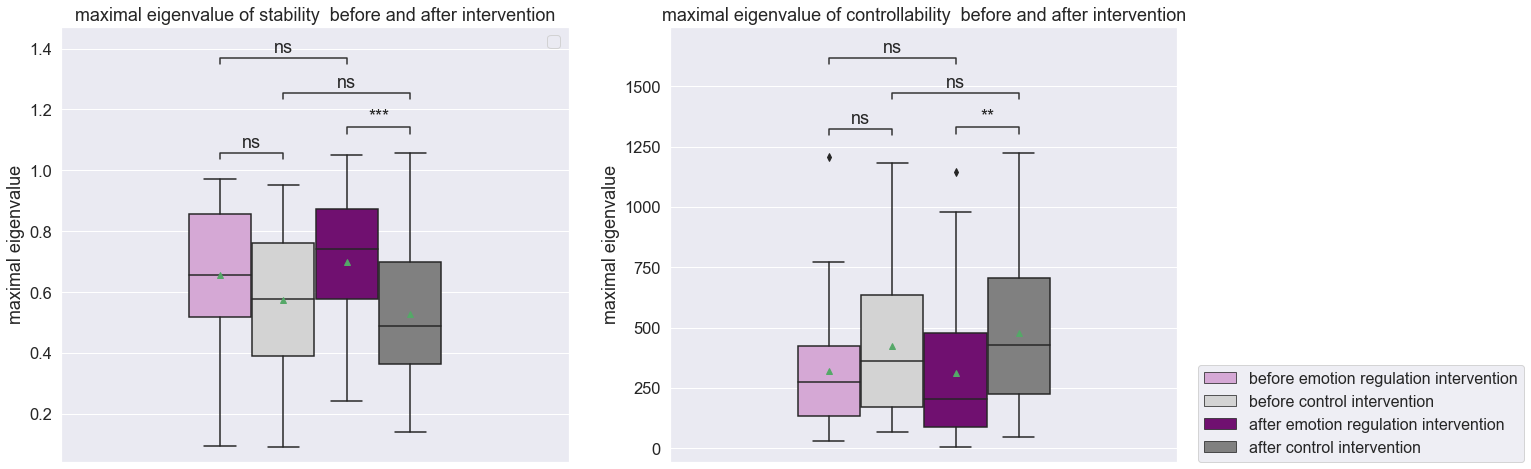

In [18]:
pairs = []
for t in range(2):
    pairs.append([('val', 0+t), ('val', 2+t)])
    pairs.append([('val', t+(t*1)), ('val', t+(t*1)+1)])
fig = plt.figure(figsize=(20,8))
for i,p in enumerate([dynamics, controls]):
    ax = fig.add_subplot(1,2,i+1)
    plot_data = np.abs(p['val'][0,:,:])
    pval = []
    for t in range(2):
        tstats = scipy.stats.mannwhitneyu(plot_data[df['randomized_condition']==0,t], \
                                           plot_data[df['randomized_condition']==1,t])
        pval.append(tstats[1])
        print(np.round(tstats,3))
    Nsj = len(df)
    tmp = pd.DataFrame(np.hstack((plot_data[:,0], plot_data[:,1])), columns=['val'])
    tmp['time'] = np.hstack((np.zeros(Nsj),np.ones(Nsj)))
    tmp['condition'] = 2*df['randomized_condition'].to_list()
    tmp['condition_time'] = tmp['time'] + tmp['condition'] * 2
    df_melted = tmp.melt(id_vars=['condition_time'], value_vars=['val'], value_name='rating', var_name='category')
    fig,ax = emostats.plot_group_difference(df=df_melted, pairs=pairs, data_labels=['eigenval'], \
                                           data_name='maximal eigenvalue of ' + label[i] + ' ', fig=fig, ax=ax)
    if i ==0: plt.legend([])
    ax.set(ylabel='maximal eigenvalue', xlabel='', xticklabels='')
    plt.savefig('/Users/jolandamalamud/Desktop/' + label[i] + 'val.png', bbox_inches='tight')
#     plt.savefig(filepath + '/results/figures/' + label[i] + 'val.png', bbox_inches='tight')

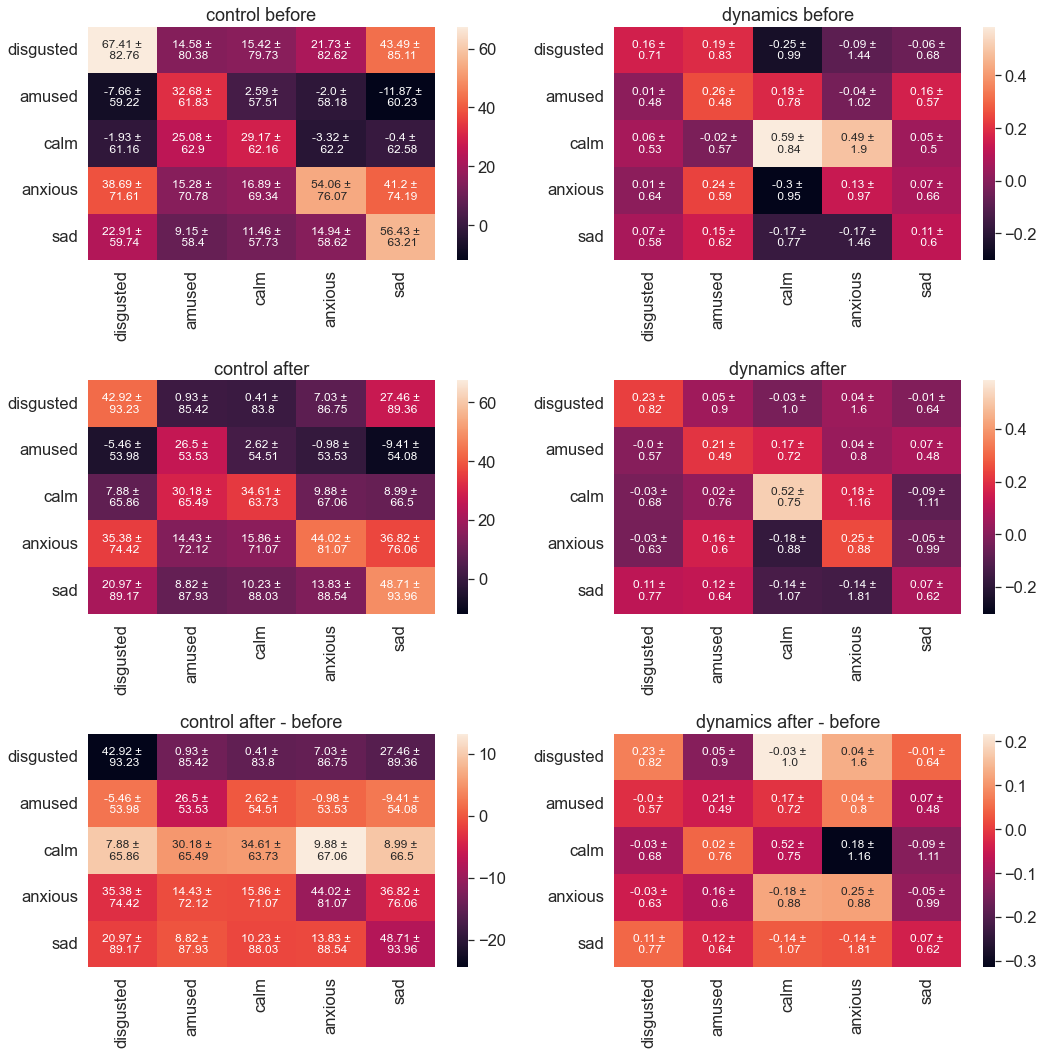

In [19]:
# average dynamics and control matrix all participants
aux.plot_matrices(controls, dynamics, np.ones(len(df))==1, mood_categories)

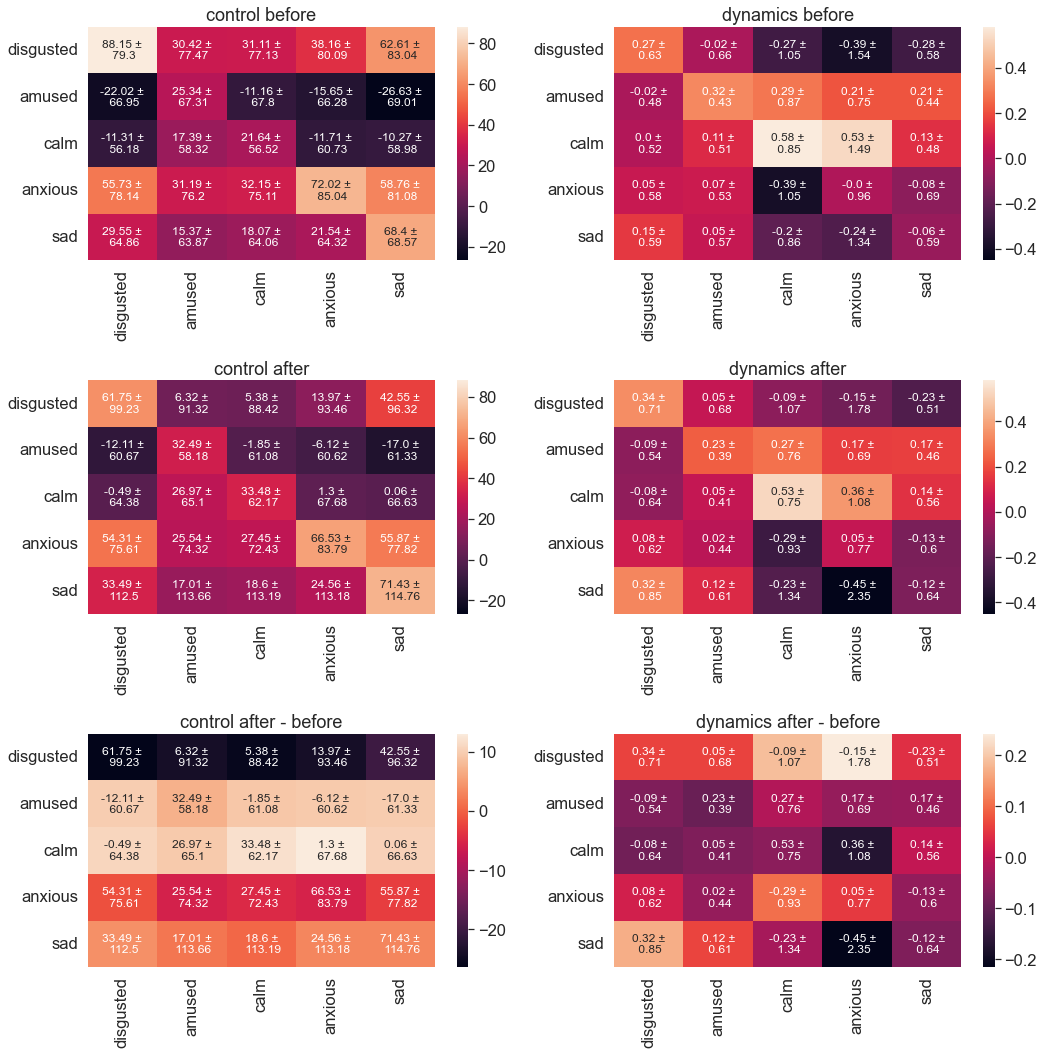

In [20]:
# average dynamics and control matrix only participants in distancing group
aux.plot_matrices(controls, dynamics, df['randomized_condition']==0, mood_categories)

----
Relation with symptoms
--

In [21]:
df_questionnaire = pd.read_csv('../results/questionnaire_data.csv',index_col=[0])
questionnaires = ['phq', 'gad', 'ders']
df_questionnaire = df_questionnaire.drop(index=ex).reset_index(drop=True)

In [22]:
# create dicts
var = 'val'
dict_data = dict()
for t in ['t1', 't2', 'change']:
    for i in [dynamics, controls]:
        dict_data['' + var + '_' + t] = i[var][:,:,0]
        

In [39]:
# maximal eigenvalues related to symtpoms
df_mood = df.copy()
timing = {
          'controlval_t1': controls['val'][0,:,0], \
          'controlval_t2': controls['val'][0,:,1], \
          'controlval_change': controls['val'][0,:,1] - controls['val'][0,:,0], \
          'dynamicsval_t1': dynamics['val'][0,:,0], \
          'dynamicsval_t2': dynamics['val'][0,:,1], \
          'dynamicsval_change': dynamics['val'][0,:,1] - dynamics['val'][0,:,0], \
          'mean_change': np.nanmean(mood_ratings[int(np.shape(mood_ratings)[0]/2)+1:,:,:],axis=0).T - \
                  np.nanmean(mood_ratings[1:int(np.shape(mood_ratings)[0]/2),:,:],axis=0).T, \
         }
for j in timing.items():
    if len(np.shape(j[1])) > 1: mood_columns = [i + '_' + j[0] for i in mood_categories]
    else: mood_columns = [j[0]]
    tmp = pd.DataFrame(np.abs(j[1]),columns=mood_columns)
    df_mood = pd.concat((df_mood,tmp), axis=1)
    for i in mood_columns: df_mood[i] = prep.zscore(df_mood[i])

df_mood = pd.concat((df_mood,df_questionnaire[questionnaires]), axis=1)


In [25]:
def run_model(k, glm_formula, q, df_mood, glmstats, idx):
    model = smf.glm(k + glm_formula[0] + q, df_mood, missing='drop').fit()
    for g in glm_formula[1]:
        tmp = prep.convert_stats_table(model,g)
        glmstats.append([tmp.values[i] for i in stats_items])
        idx.append(tmp.name + ' -> ' + list(timing.keys())[d])
    return glmstats, idx, tmp

formula = [[' ~ ', [1]], \
           [' ~ randomized_condition + ', [1,2]], 
            [' ~ randomized_condition * ', [3]]]

stats_items = [0, 3, 4, 5]
df_stats_all = []
for q in questionnaires:
    df_stats = pd.DataFrame()
    for m in ['control', 'dynamic']:
        glmstats, idx = [], []
        mood_columns = [i for i in df_mood.columns if m in i]
        for d, k in enumerate(mood_columns):
            if '1' in k: 
                glm_formula = formula[0]
                glmstats, idx, tmp = run_model(k, glm_formula, q, df_mood, glmstats, idx)
            elif '2' in k or 'change' in k: 
                glm_formula = formula[1:]
                for gg in glm_formula:
                    glmstats, idx, tmp = run_model(k, gg, q, df_mood, glmstats, idx)
            else: 
                glm_formula = [' ~ ', [1]]
                glmstats, idx, tmp = run_model(k, glm_formula, q, df_mood, glmstats, idx)
        statscolumns = [tmp.index[i] for i in stats_items] 
        header = [np.repeat(np.array(m),4), 
                    np.array(statscolumns)] 
        df_stats = pd.concat((df_stats, \
                              pd.DataFrame(glmstats, \
                                           columns=header, index=idx)),axis=1)
    idx = []
    for m in ['control', 'dynamic']:
        idx.append(df_stats[(m, 'P>|z|')] < 0.001)
    df_stats = df_stats.round(3)
    for i,m in enumerate(['control', 'dynamic']): df_stats[(m, 'P>|z|')][idx[i]] = '$<$0.001'
    display(df_stats)
#     df_stats_all.append(df_stats)
#     print(df_stats.to_latex(escape=False))

control                       \
                                                 coef  P>|z| [0.025 0.975]   
phq -> controlval_t1                           -0.009  0.586 -0.043  0.024   
randomized_condition -> controlval_t2          -0.523  0.005 -0.890 -0.157   
phq -> controlval_t2                           -0.031  0.054 -0.063  0.001   
randomized_condition:phq -> controlval_t2       0.037  0.264 -0.028  0.101   
randomized_condition -> controlval_change      -0.395  0.041 -0.772 -0.017   
phq -> controlval_change                       -0.018  0.282 -0.051  0.015   
randomized_condition:phq -> controlval_change  -0.018  0.602 -0.084  0.049   

                                              dynamic                          
                                                 coef     P>|z| [0.025 0.975]  
phq -> controlval_t1                            0.012       0.5 -0.022  0.045  
randomized_condition -> controlval_t2           0.706  $<$0.001  0.345  1.067  
phq -> controlval_t2                            0.013     0.417 -0.018  0.045  
randomized_condition:phq -> controlval_t2      -0.012     0.714 -0.076  0.052  
randomized_condition -> controlval_change       0.392     0.042  0.014  0.771  
phq -> controlval_change                       -0.022     0.196 -0.055  0.011  
randomized_condition:phq -> controlval_change   0.020     0.557 -0.047  0.087

control                       \
                                                 coef  P>|z| [0.025 0.975]   
gad -> controlval_t1                           -0.004  0.855 -0.043  0.036   
randomized_condition -> controlval_t2          -0.562  0.003 -0.932 -0.192   
gad -> controlval_t2                           -0.018  0.351 -0.056  0.020   
randomized_condition:gad -> controlval_t2       0.029  0.460 -0.047  0.105   
randomized_condition -> controlval_change      -0.418  0.030 -0.795 -0.040   
gad -> controlval_change                       -0.013  0.500 -0.052  0.025   
randomized_condition:gad -> controlval_change  -0.048  0.227 -0.125  0.030   

                                              dynamic                          
                                                 coef     P>|z| [0.025 0.975]  
gad -> controlval_t1                            0.008     0.674 -0.031  0.048  
randomized_condition -> controlval_t2           0.723  $<$0.001  0.363  1.083  
gad -> controlval_t2                            0.009     0.618 -0.027  0.046  
randomized_condition:gad -> controlval_t2      -0.010     0.801 -0.084  0.065  
randomized_condition -> controlval_change       0.359      0.06 -0.015  0.733  
gad -> controlval_change                       -0.036     0.064 -0.074  0.002  
randomized_condition:gad -> controlval_change   0.037      0.34 -0.039  0.114

control                       \
                                                  coef  P>|z| [0.025 0.975]   
ders -> controlval_t1                            0.004  0.678 -0.013  0.020   
randomized_condition -> controlval_t2           -0.558  0.003 -0.927 -0.188   
ders -> controlval_t2                           -0.008  0.355 -0.023  0.008   
randomized_condition:ders -> controlval_t2       0.018  0.270 -0.014  0.050   
randomized_condition -> controlval_change       -0.414  0.032 -0.792 -0.036   
ders -> controlval_change                       -0.003  0.746 -0.019  0.014   
randomized_condition:ders -> controlval_change  -0.017  0.313 -0.049  0.016   

                                               dynamic                          
                                                  coef     P>|z| [0.025 0.975]  
ders -> controlval_t1                           -0.000     0.975 -0.017  0.016  
randomized_condition -> controlval_t2            0.721  $<$0.001  0.362  1.080  
ders -> controlval_t2                            0.008     0.313 -0.008  0.023  
randomized_condition:ders -> controlval_t2      -0.007     0.666 -0.038  0.024  
randomized_condition -> controlval_change        0.367     0.051 -0.001  0.736  
ders -> controlval_change                       -0.021      0.01 -0.037 -0.005  
randomized_condition:ders -> controlval_change  -0.002      0.92 -0.034  0.030

In [63]:
df_mood = df.copy()
timing = {
          'controlval_t1': controls['val'][0,:,0], \
          'controlval_t2': controls['val'][0,:,1], \
          'controlval_change': controls['val'][0,:,1] - controls['val'][0,:,0], \
          'dynamicsval_t1': dynamics['val'][0,:,0], \
          'dynamicsval_t2': dynamics['val'][0,:,1], \
          'dynamicsval_change': dynamics['val'][0,:,1] - dynamics['val'][0,:,0], \
          'controlvec_t1': controls['vec'][:,0,:,0].T, \
          'controlvec_t2': controls['vec'][:,0,:,1].T, \
          'controlvec_change': controls['vec'][:,0,:,1].T - controls['vec'][:,0,:,0].T, \
          'dynamicsvec_t1': dynamics['vec'][:,0,:,0].T, \
          'dynamicsvec_t2': dynamics['vec'][:,0,:,1].T, \
          'dynamicsvec_change': dynamics['vec'][:,0,:,1].T - dynamics['vec'][:,0,:,0].T, \
          'mean_change': np.nanmean(mood_ratings[int(np.shape(mood_ratings)[0]/2)+1:,:,:],axis=0).T - \
          np.nanmean(mood_ratings[1:int(np.shape(mood_ratings)[0]/2),:,:],axis=0).T, \
         }

In [69]:
for i in range(5):
    print(mood_categories[i], end=': ')
    print(scipy.stats.pearsonr(timing['mean_change'][df['randomized_condition']==1,i], \
                      timing['controlval_change'][df['randomized_condition']==1]))
for i in range(5):
    print(mood_categories[i], end=': ')
    print(scipy.stats.pearsonr(timing['mean_change'][df['randomized_condition']==1,i], \
                      timing['dynamicsval_change'][df['randomized_condition']==1]))

disgusted: ((0.12654980133618926+0j), 0.3572224547105272)
amused: ((0.17174279095798875+0j), 0.2099279156604805)
calm: ((0.15189563785317012+0j), 0.26827115707694077)
anxious: ((0.22552713917533018+0j), 0.09781448060433046)
sad: ((0.10871930111122176+0j), 0.42946317653931915)
disgusted: ((-0.331790277288267+0j), 0.013336841122705929)
amused: ((-0.0491410794202229+0j), 0.7216274363296484)
calm: ((0.13261945076756387+0j), 0.3344377532965723)
anxious: ((-0.19936038057936378+0j), 0.1445018015552189)
sad: ((-0.2227523536529734+0j), 0.10212411790072537)


In [71]:
for i in range(5):
    print(mood_categories[i], end=': ')
    print(scipy.stats.pearsonr(timing['mean_change'][df['randomized_condition']==1,i], \
                      timing['controlvec_change'][df['randomized_condition']==1,i]))
for i in range(5):
    print(mood_categories[i], end=': ')
    print(scipy.stats.pearsonr(timing['mean_change'][df['randomized_condition']==1,i], \
                      timing['dynamicsvec_change'][df['randomized_condition']==1,i]))

disgusted: ((-0.07420187554994263+0j), 0.5903013937963744)
amused: ((0.10499209799757776+0j), 0.4455410731019821)
calm: ((0.1517907814282516+0j), 0.2686055808225611)
anxious: ((-0.35041252103311893+0j), 0.008721784975778362)
sad: ((-0.29621896573580964+0j), 0.02809898064589817)
disgusted: ((0.07066422140743256+0j), 0.6081860434769)
amused: ((0.23672276817983415+0j), 0.08184392159413278)
calm: ((0.4157738031275231+0j), 0.0015946022105401503)
anxious: ((0.14124441979780333+0j), 0.30366543498789184)
sad: ((0.11318917554798111+0j), 0.4106208333496925)


/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5179: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[0] = start
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5180: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N + 1] = end
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5183: ComplexWarning: Casting comp

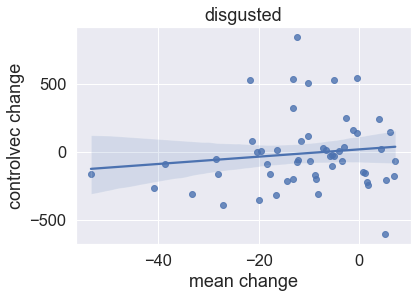

/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5179: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[0] = start
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5180: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N + 1] = end
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5183: ComplexWarning: Casting comp

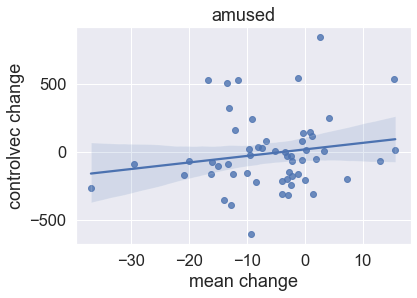

/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5179: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[0] = start
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5180: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N + 1] = end
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5183: ComplexWarning: Casting comp

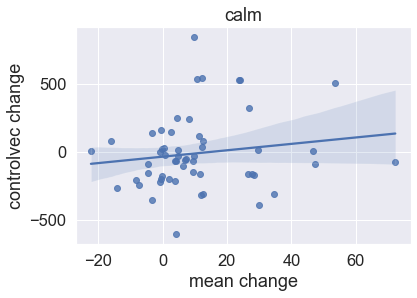

/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5179: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[0] = start
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5180: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N + 1] = end
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5183: ComplexWarning: Casting comp

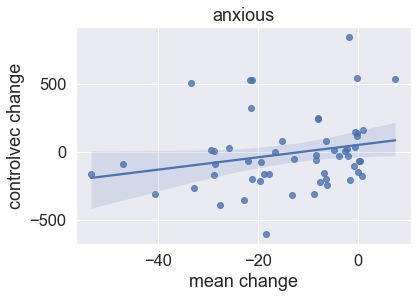

/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5179: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[0] = start
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5180: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N + 1] = end
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5183: ComplexWarning: Casting comp

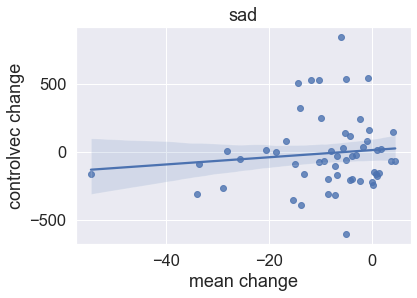

In [93]:
for i in range(5):
    b = sns.regplot(x=timing['mean_change'][df['randomized_condition']==1,i], \
                          y=timing['controlval_change'][df['randomized_condition']==1])
    b.set(xlabel='mean change', ylabel='controlval change', title=mood_categories[i])
    plt.show()

/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5179: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[0] = start
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5180: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N + 1] = end
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5183: ComplexWarning: Casting comp

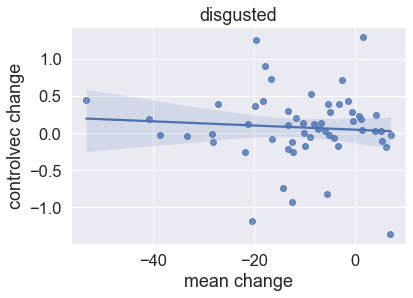

/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5179: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[0] = start
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5180: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N + 1] = end
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5183: ComplexWarning: Casting comp

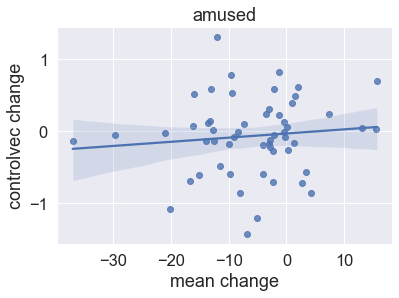

/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5179: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[0] = start
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5180: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N + 1] = end
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5183: ComplexWarning: Casting comp

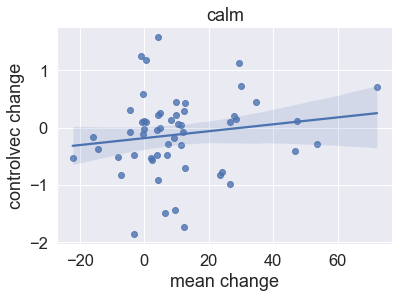

/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5179: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[0] = start
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5180: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N + 1] = end
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5183: ComplexWarning: Casting comp

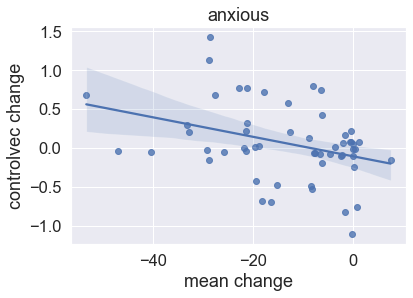

/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5179: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[0] = start
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5180: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N + 1] = end
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5183: ComplexWarning: Casting comp

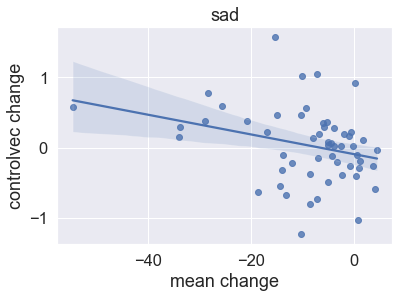

In [92]:
for i in range(5):
    b = sns.regplot(x=timing['mean_change'][df['randomized_condition']==1,i], \
                          y=timing['controlvec_change'][df['randomized_condition']==1,i])
    b.set(xlabel='mean change', ylabel='controlvec change', title=mood_categories[i])
    plt.show()

In [62]:
for i in range(5):
    print(scipy.stats.spearmanr(timing['controlvec_change'][df['randomized_condition']==1,i], \
                      timing['mean_change'][df['randomized_condition']==1,i]))

SpearmanrResult(correlation=-0.016450216450216458, pvalue=0.9051137993843507)
SpearmanrResult(correlation=0.11486291486291489, pvalue=0.40369005380884027)
SpearmanrResult(correlation=0.15772290267541786, pvalue=0.25012193599936117)
SpearmanrResult(correlation=-0.32424242424242433, pvalue=0.015732783160689903)
SpearmanrResult(correlation=-0.31630591630591637, pvalue=0.01863950433889428)


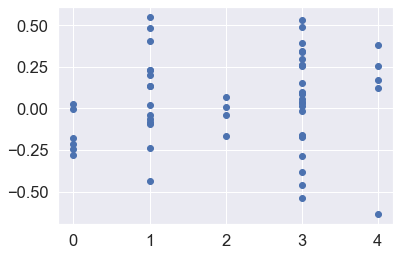

In [34]:
plt.scatter(df['intervention_success'][df['randomized_condition']==1], \
            timing['dynamicsval_change'][df['randomized_condition']==1])

In [54]:
df_mood = df.copy()
timing = {'controlvec_t1': controls['vec'][:,0,:,0].T, \
          'controlvec_t2': controls['vec'][:,0,:,1].T, \
          'controlvec_change': controls['vec'][:,0,:,1].T - controls['vec'][:,0,:,0].T, \
          'dynamicsvec_t1': dynamics['vec'][:,0,:,0].T, \
          'dynamicsvec_t2': dynamics['vec'][:,0,:,1].T, \
          'dynamicsvec_change': dynamics['vec'][:,0,:,1].T - dynamics['vec'][:,0,:,0].T, \
            'mean_change': np.nanmean(mood_ratings[int(np.shape(mood_ratings)[0]/2)+1:,:,:],axis=0).T - \
          np.nanmean(mood_ratings[1:int(np.shape(mood_ratings)[0]/2),:,:],axis=0).T, \
         }
for j in timing.items():
    if len(np.shape(j[1])) > 1: mood_columns = [i + '_' + j[0] for i in mood_categories]
    else: mood_columns = [j[0]]
    tmp = pd.DataFrame(np.abs(j[1]),columns=mood_columns)
    df_mood = pd.concat((df_mood,tmp), axis=1)
    for i in mood_columns: df_mood[i] = prep.zscore(df_mood[i])

df_mood = pd.concat((df_mood,df_questionnaire[questionnaires]), axis=1)

In [26]:
def run_model(k, glm_formula, q, df_mood, glmstats, idx):
    model = smf.glm(k + glm_formula[0] + q, df_mood, missing='drop').fit()
    for g in glm_formula[1]:
        tmp = prep.convert_stats_table(model,g)
        glmstats.append([tmp.values[i] for i in stats_items])
        idx.append(tmp.name + ' -> ' + list(timing.keys())[d])
    return glmstats, idx, tmp

formula = [[' ~ ', [1]], \
           [' ~ randomized_condition + ', [1,2]], 
            [' ~ randomized_condition * ', [3]]]

stats_items = [0, 3, 4, 5]
df_stats_all = []
for q in questionnaires:
    df_stats = pd.DataFrame()
    for m in mood_categories:
        glmstats, idx = [], []
        mood_columns = [i for i in df_mood.columns if m in i]
        for d, k in enumerate(mood_columns):
            if '1' in k: 
                glm_formula = formula[0]
                glmstats, idx, tmp = run_model(k, glm_formula, q, df_mood, glmstats, idx)
            elif '2' in k or 'change' in k: 
                glm_formula = formula[1:]
                for gg in glm_formula:
                    glmstats, idx, tmp = run_model(k, gg, q, df_mood, glmstats, idx)
            else: 
                glm_formula = [' ~ ', [1]]
                glmstats, idx, tmp = run_model(k, glm_formula, q, df_mood, glmstats, idx)
        statscolumns = [tmp.index[i] for i in stats_items] 
        header = [np.repeat(np.array(m),4), 
                    np.array(statscolumns)] 
        df_stats = pd.concat((df_stats, \
                              pd.DataFrame(glmstats, \
                                           columns=header, index=idx)),axis=1)
    idx = []
    for m in mood_categories:
        idx.append(df_stats[(m, 'P>|z|')] < 0.001)
    df_stats = df_stats.round(3)
    for i,m in enumerate(mood_categories): df_stats[(m, 'P>|z|')][idx[i]] = '$<$0.001'
    display(df_stats)
    df_stats_all.append(df_stats)
    print(df_stats.to_latex(escape=False))

/var/folders/5z/t44r3krd25sftrcjrj8j__4m0000gn/T/ipykernel_10161/2161400437.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for i,m in enumerate(mood_categories): df_stats[(m, 'P>|z|')][idx[i]] = '$<$0.001'


disgusted                       \
                                                coef  P>|z| [0.025 0.975]   
phq -> controlvec_t1                           0.128  0.190 -0.064  0.320   
randomized_condition -> controlvec_t2         -0.375  0.052 -0.753  0.004   
phq -> controlvec_t2                           0.145  0.134 -0.045  0.335   
randomized_condition:phq -> controlvec_t2     -0.132  0.500 -0.516  0.252   
phq -> dynamicsvec_t1                          0.004  0.972 -0.190  0.197   
randomized_condition -> dynamicsvec_t2        -0.067  0.736 -0.455  0.321   
phq -> dynamicsvec_t2                         -0.022  0.827 -0.217  0.173   
randomized_condition:phq -> dynamicsvec_t2     0.227  0.257 -0.165  0.618   

                                           amused                        calm  \
                                             coef  P>|z| [0.025 0.975]   coef   
phq -> controlvec_t1                       -0.203  0.035 -0.392 -0.014 -0.108   
randomized_condition -> controlvec_t2       0.150  0.447 -0.237  0.537  0.692   
phq -> controlvec_t2                       -0.019  0.849 -0.213  0.176 -0.038   
randomized_condition:phq -> controlvec_t2   0.234  0.241 -0.157  0.625 -0.149   
phq -> dynamicsvec_t1                      -0.172  0.076 -0.363  0.018 -0.097   
randomized_condition -> dynamicsvec_t2     -0.327  0.091 -0.705  0.052  0.561   
phq -> dynamicsvec_t2                       0.170  0.079 -0.020  0.360 -0.097   
randomized_condition:phq -> dynamicsvec_t2  0.064  0.746 -0.321  0.448 -0.022   

                                                                   anxious  \
                                               P>|z| [0.025 0.975]    coef   
phq -> controlvec_t1                           0.272 -0.300  0.084  -0.006   
randomized_condition -> controlvec_t2       $<$0.001  0.327  1.056  -0.278   
phq -> controlvec_t2                           0.688 -0.221  0.146  -0.020   
randomized_condition:phq -> controlvec_t2       0.43 -0.518  0.221   0.287   
phq -> dynamicsvec_t1                          0.323 -0.289  0.095   0.070   
randomized_condition -> dynamicsvec_t2         0.003  0.189  0.933  -0.255   
phq -> dynamicsvec_t2                          0.307 -0.284  0.090  -0.036   
randomized_condition:phq -> dynamicsvec_t2     0.911 -0.400  0.356   0.088   

                                                                   sad  \
                                            P>|z| [0.025 0.975]   coef   
phq -> controlvec_t1                        0.953 -0.199  0.187  0.171   
randomized_condition -> controlvec_t2       0.157 -0.662  0.107 -0.660   
phq -> controlvec_t2                        0.840 -0.213  0.173 -0.036   
randomized_condition:phq -> controlvec_t2   0.145 -0.099  0.674 -0.116   
phq -> dynamicsvec_t1                       0.479 -0.123  0.263  0.190   
randomized_condition -> dynamicsvec_t2      0.194 -0.639  0.130 -0.393   
phq -> dynamicsvec_t2                       0.716 -0.229  0.157  0.192   
randomized_condition:phq -> dynamicsvec_t2  0.659 -0.303  0.479 -0.079   

                                                                    
                                               P>|z| [0.025 0.975]  
phq -> controlvec_t1                           0.078 -0.019  0.362  
randomized_condition -> controlvec_t2       $<$0.001 -1.026 -0.295  
phq -> controlvec_t2                             0.7 -0.220  0.148  
randomized_condition:phq -> controlvec_t2      0.539 -0.488  0.255  
phq -> dynamicsvec_t1                           0.05 -0.000  0.380  
randomized_condition -> dynamicsvec_t2          0.04 -0.768 -0.018  
phq -> dynamicsvec_t2                          0.046  0.004  0.380  
randomized_condition:phq -> dynamicsvec_t2     0.683 -0.460  0.301

\begin{tabular}{lrrrrrrrrrlrrrrrrrlrr}
\toprule
{} & \multicolumn{4}{l}{disgusted} & \multicolumn{4}{l}{amused} & \multicolumn{4}{l}{calm} & \multicolumn{4}{l}{anxious} & \multicolumn{4}{l}{sad} \\
{} &      coef &  P>|z| & [0.025 & 0.975] &   coef &  P>|z| & [0.025 & 0.975] &   coef &     P>|z| & [0.025 & 0.975] &    coef &  P>|z| & [0.025 & 0.975] &   coef &     P>|z| & [0.025 & 0.975] \\
\midrule
phq -> controlvec_t1                       &     0.128 &  0.190 & -0.064 &  0.320 & -0.203 &  0.035 & -0.392 & -0.014 & -0.108 &     0.272 & -0.300 &  0.084 &  -0.006 &  0.953 & -0.199 &  0.187 &  0.171 &     0.078 & -0.019 &  0.362 \\
randomized_condition -> controlvec_t2      &    -0.375 &  0.052 & -0.753 &  0.004 &  0.150 &  0.447 & -0.237 &  0.537 &  0.692 &  $<$0.001 &  0.327 &  1.056 &  -0.278 &  0.157 & -0.662 &  0.107 & -0.660 &  $<$0.001 & -1.026 & -0.295 \\
phq -> controlvec_t2                       &     0.145 &  0.134 & -0.045 &  0.335 & -0.019 &  0.849 & -0.213 &  0.176 & -0.03

/var/folders/5z/t44r3krd25sftrcjrj8j__4m0000gn/T/ipykernel_10161/2161400437.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for i,m in enumerate(mood_categories): df_stats[(m, 'P>|z|')][idx[i]] = '$<$0.001'


disgusted                       \
                                                coef  P>|z| [0.025 0.975]   
gad -> controlvec_t1                           0.283  0.003  0.099  0.467   
randomized_condition -> controlvec_t2         -0.335  0.077 -0.707  0.036   
gad -> controlvec_t2                           0.219  0.021  0.033  0.404   
randomized_condition:gad -> controlvec_t2      0.010  0.960 -0.363  0.382   
gad -> dynamicsvec_t1                         -0.003  0.976 -0.195  0.189   
randomized_condition -> dynamicsvec_t2        -0.077  0.692 -0.461  0.306   
gad -> dynamicsvec_t2                         -0.117  0.231 -0.309  0.075   
randomized_condition:gad -> dynamicsvec_t2     0.059  0.764 -0.326  0.444   

                                           amused                        calm  \
                                             coef  P>|z| [0.025 0.975]   coef   
gad -> controlvec_t1                       -0.225  0.019 -0.412 -0.038 -0.167   
randomized_condition -> controlvec_t2       0.144  0.463 -0.241  0.530  0.676   
gad -> controlvec_t2                       -0.043  0.664 -0.235  0.150 -0.164   
randomized_condition:gad -> controlvec_t2   0.073  0.712 -0.314  0.460 -0.292   
gad -> dynamicsvec_t1                      -0.108  0.270 -0.298  0.083 -0.095   
randomized_condition -> dynamicsvec_t2     -0.289  0.137 -0.669  0.091  0.542   
gad -> dynamicsvec_t2                       0.112  0.247 -0.078  0.302 -0.026   
randomized_condition:gad -> dynamicsvec_t2  0.139  0.473 -0.241  0.520 -0.068   

                                                                   anxious  \
                                               P>|z| [0.025 0.975]    coef   
gad -> controlvec_t1                           0.083 -0.357  0.022   0.037   
randomized_condition -> controlvec_t2       $<$0.001  0.318  1.033  -0.282   
gad -> controlvec_t2                           0.072 -0.342  0.015  -0.018   
randomized_condition:gad -> controlvec_t2      0.107 -0.647  0.063   0.369   
gad -> dynamicsvec_t1                          0.331 -0.286  0.096   0.195   
randomized_condition -> dynamicsvec_t2         0.004  0.169  0.914  -0.258   
gad -> dynamicsvec_t2                          0.782 -0.212  0.159   0.060   
randomized_condition:gad -> dynamicsvec_t2     0.719 -0.442  0.305   0.098   

                                                                   sad  \
                                            P>|z| [0.025 0.975]   coef   
gad -> controlvec_t1                        0.708 -0.155  0.229  0.028   
randomized_condition -> controlvec_t2       0.148 -0.665  0.100 -0.665   
gad -> controlvec_t2                        0.851 -0.209  0.173  0.039   
randomized_condition:gad -> controlvec_t2   0.055 -0.009  0.747 -0.059   
gad -> dynamicsvec_t1                       0.042  0.007  0.383  0.109   
randomized_condition -> dynamicsvec_t2      0.186 -0.641  0.124 -0.351   
gad -> dynamicsvec_t2                       0.541 -0.131  0.251  0.115   
randomized_condition:gad -> dynamicsvec_t2  0.617 -0.286  0.482 -0.113   

                                                                    
                                               P>|z| [0.025 0.975]  
gad -> controlvec_t1                           0.779 -0.165  0.219  
randomized_condition -> controlvec_t2       $<$0.001 -1.029 -0.301  
gad -> controlvec_t2                           0.676 -0.143  0.221  
randomized_condition:gad -> controlvec_t2      0.753 -0.425  0.307  
gad -> dynamicsvec_t1                          0.263 -0.082  0.300  
randomized_condition -> dynamicsvec_t2         0.069 -0.729  0.027  
gad -> dynamicsvec_t2                          0.232 -0.074  0.304  
randomized_condition:gad -> dynamicsvec_t2      0.56 -0.492  0.266

\begin{tabular}{lrrrrrrrrrlrrrrrrrlrr}
\toprule
{} & \multicolumn{4}{l}{disgusted} & \multicolumn{4}{l}{amused} & \multicolumn{4}{l}{calm} & \multicolumn{4}{l}{anxious} & \multicolumn{4}{l}{sad} \\
{} &      coef &  P>|z| & [0.025 & 0.975] &   coef &  P>|z| & [0.025 & 0.975] &   coef &     P>|z| & [0.025 & 0.975] &    coef &  P>|z| & [0.025 & 0.975] &   coef &     P>|z| & [0.025 & 0.975] \\
\midrule
gad -> controlvec_t1                       &     0.283 &  0.003 &  0.099 &  0.467 & -0.225 &  0.019 & -0.412 & -0.038 & -0.167 &     0.083 & -0.357 &  0.022 &   0.037 &  0.708 & -0.155 &  0.229 &  0.028 &     0.779 & -0.165 &  0.219 \\
randomized_condition -> controlvec_t2      &    -0.335 &  0.077 & -0.707 &  0.036 &  0.144 &  0.463 & -0.241 &  0.530 &  0.676 &  $<$0.001 &  0.318 &  1.033 &  -0.282 &  0.148 & -0.665 &  0.100 & -0.665 &  $<$0.001 & -1.029 & -0.301 \\
gad -> controlvec_t2                       &     0.219 &  0.021 &  0.033 &  0.404 & -0.043 &  0.664 & -0.235 &  0.150 & -0.16

/var/folders/5z/t44r3krd25sftrcjrj8j__4m0000gn/T/ipykernel_10161/2161400437.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for i,m in enumerate(mood_categories): df_stats[(m, 'P>|z|')][idx[i]] = '$<$0.001'


disgusted                          \
                                                 coef     P>|z| [0.025 0.975]   
ders -> controlvec_t1                           0.266     0.005  0.079  0.452   
randomized_condition -> controlvec_t2          -0.345     0.057 -0.701  0.011   
ders -> controlvec_t2                           0.350  $<$0.001  0.171  0.529   
randomized_condition:ders -> controlvec_t2     -0.037     0.839 -0.397  0.323   
ders -> dynamicsvec_t1                         -0.084     0.395 -0.276  0.109   
randomized_condition -> dynamicsvec_t2         -0.071     0.718 -0.457  0.315   
ders -> dynamicsvec_t2                         -0.042     0.667 -0.236  0.151   
randomized_condition:ders -> dynamicsvec_t2     0.058      0.77 -0.332  0.448   

                                            amused                       \
                                              coef  P>|z| [0.025 0.975]   
ders -> controlvec_t1                       -0.271  0.004 -0.457 -0.085   
randomized_condition -> controlvec_t2        0.146  0.456 -0.238  0.531   
ders -> controlvec_t2                       -0.076  0.438 -0.269  0.117   
randomized_condition:ders -> controlvec_t2   0.192  0.330 -0.194  0.579   
ders -> dynamicsvec_t1                      -0.101  0.303 -0.293  0.091   
randomized_condition -> dynamicsvec_t2      -0.295  0.130 -0.676  0.087   
ders -> dynamicsvec_t2                       0.049  0.615 -0.142  0.241   
randomized_condition:ders -> dynamicsvec_t2  0.171  0.385 -0.214  0.555   

                                              calm                          \
                                              coef     P>|z| [0.025 0.975]   
ders -> controlvec_t1                       -0.242     0.012 -0.429 -0.054   
randomized_condition -> controlvec_t2        0.684  $<$0.001  0.327  1.041   
ders -> controlvec_t2                       -0.171     0.061 -0.351  0.008   
randomized_condition:ders -> controlvec_t2  -0.129     0.483 -0.489  0.231   
ders -> dynamicsvec_t1                      -0.052     0.597 -0.245  0.141   
randomized_condition -> dynamicsvec_t2       0.542     0.004  0.172  0.912   
ders -> dynamicsvec_t2                      -0.104     0.273 -0.289  0.082   
randomized_condition:ders -> dynamicsvec_t2  0.000     0.999 -0.374  0.374   

                                            anxious                       \
                                               coef  P>|z| [0.025 0.975]   
ders -> controlvec_t1                         0.077  0.435 -0.116  0.269   
randomized_condition -> controlvec_t2        -0.282  0.148 -0.663  0.100   
ders -> controlvec_t2                        -0.069  0.480 -0.261  0.123   
randomized_condition:ders -> controlvec_t2    0.335  0.084 -0.045  0.716   
ders -> dynamicsvec_t1                        0.232  0.016  0.044  0.419   
randomized_condition -> dynamicsvec_t2       -0.261  0.181 -0.645  0.122   
ders -> dynamicsvec_t2                        0.017  0.861 -0.175  0.210   
randomized_condition:ders -> dynamicsvec_t2   0.182  0.355 -0.204  0.568   

                                               sad                          
                                              coef     P>|z| [0.025 0.975]  
ders -> controlvec_t1                        0.152     0.117 -0.038  0.343  
randomized_condition -> controlvec_t2       -0.666  $<$0.001 -1.026 -0.306  
ders -> controlvec_t2                        0.145     0.116 -0.036  0.326  
randomized_condition:ders -> controlvec_t2   0.038     0.837 -0.326  0.402  
ders -> dynamicsvec_t1                       0.084     0.395 -0.109  0.276  
randomized_condition -> dynamicsvec_t2      -0.356      0.06 -0.727  0.015  
ders -> dynamicsvec_t2                       0.216     0.023  0.030  0.402  
randomized_condition:ders -> dynamicsvec_t2 -0.063     0.742 -0.438  0.312

\begin{tabular}{lrlrrrrrrrlrrrrrrrlrr}
\toprule
{} & \multicolumn{4}{l}{disgusted} & \multicolumn{4}{l}{amused} & \multicolumn{4}{l}{calm} & \multicolumn{4}{l}{anxious} & \multicolumn{4}{l}{sad} \\
{} &      coef &     P>|z| & [0.025 & 0.975] &   coef &  P>|z| & [0.025 & 0.975] &   coef &     P>|z| & [0.025 & 0.975] &    coef &  P>|z| & [0.025 & 0.975] &   coef &     P>|z| & [0.025 & 0.975] \\
\midrule
ders -> controlvec_t1                       &     0.266 &     0.005 &  0.079 &  0.452 & -0.271 &  0.004 & -0.457 & -0.085 & -0.242 &     0.012 & -0.429 & -0.054 &   0.077 &  0.435 & -0.116 &  0.269 &  0.152 &     0.117 & -0.038 &  0.343 \\
randomized_condition -> controlvec_t2       &    -0.345 &     0.057 & -0.701 &  0.011 &  0.146 &  0.456 & -0.238 &  0.531 &  0.684 &  $<$0.001 &  0.327 &  1.041 &  -0.282 &  0.148 & -0.663 &  0.100 & -0.666 &  $<$0.001 & -1.026 & -0.306 \\
ders -> controlvec_t2                       &     0.350 &  $<$0.001 &  0.171 &  0.529 & -0.076 &  0.438 & -0.269 &

In [27]:
from matplotlib.gridspec import SubplotSpec
def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

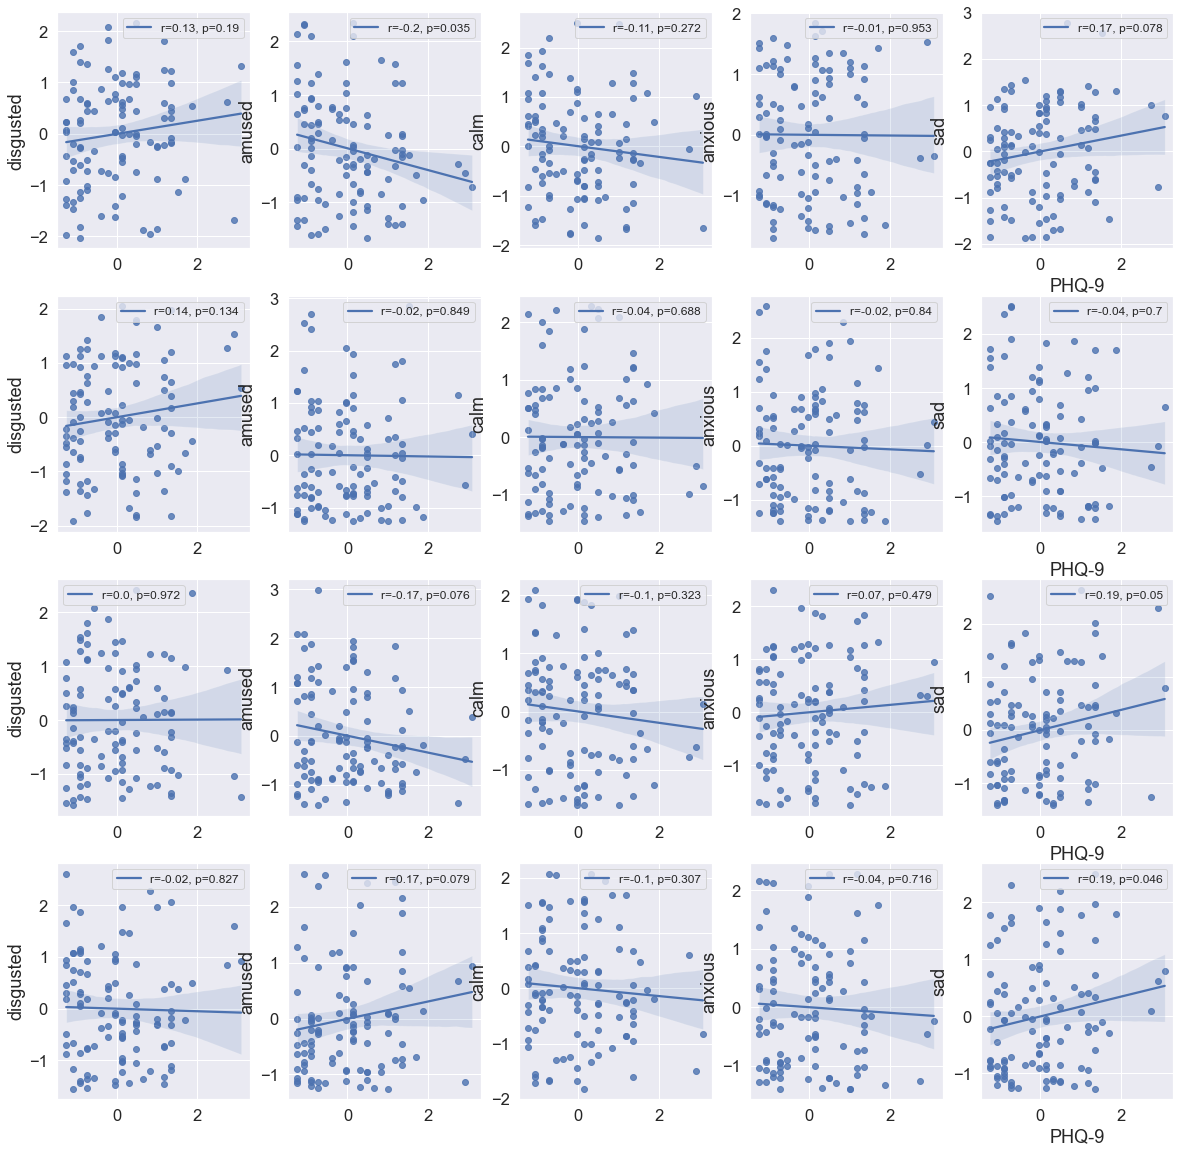

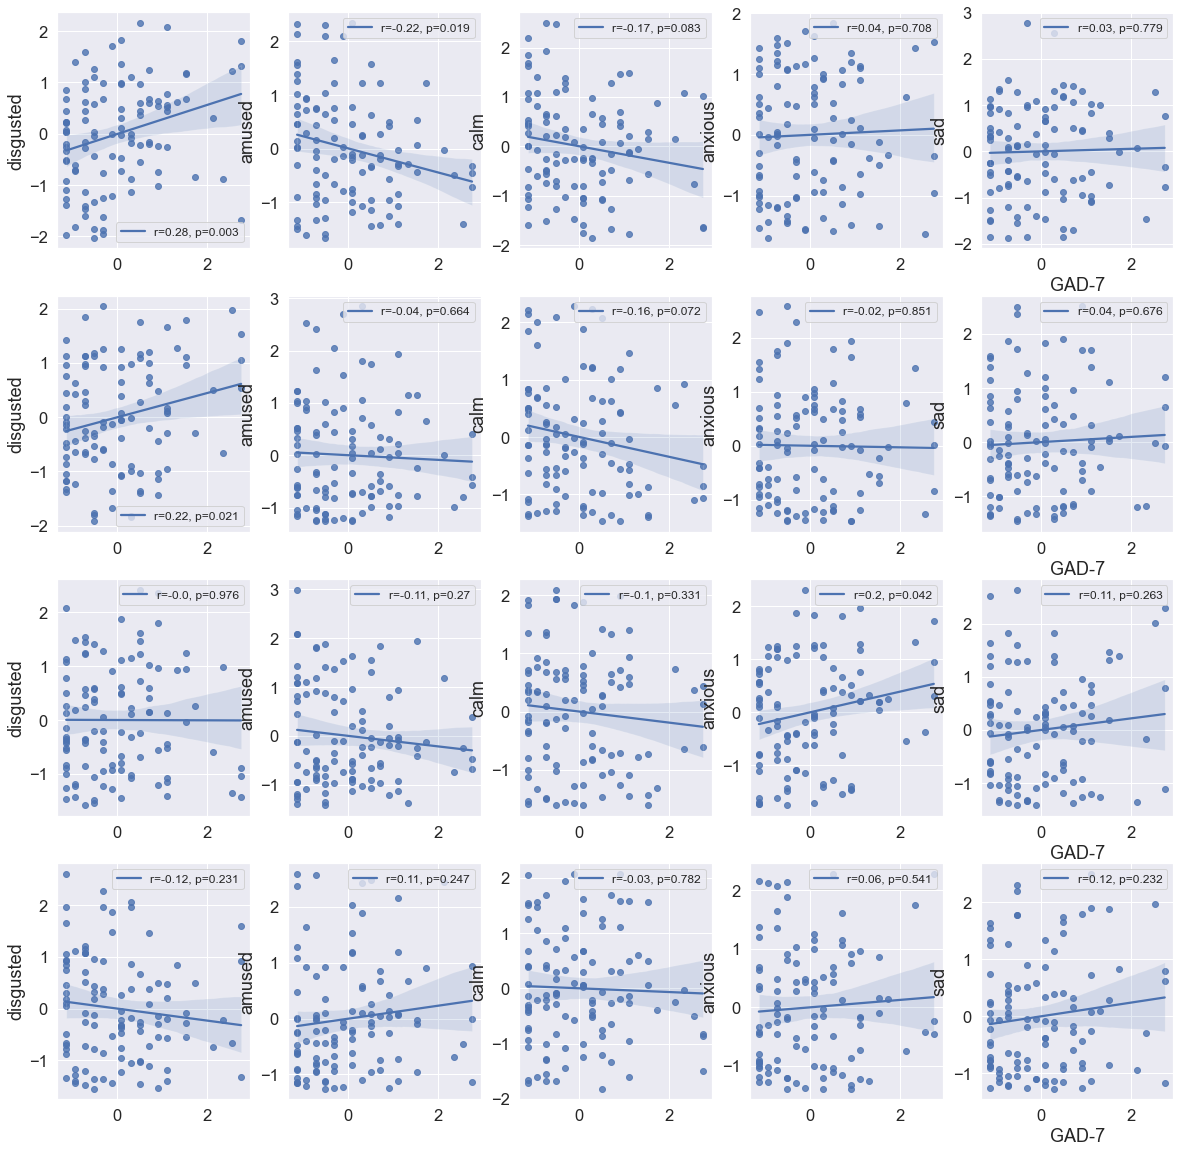

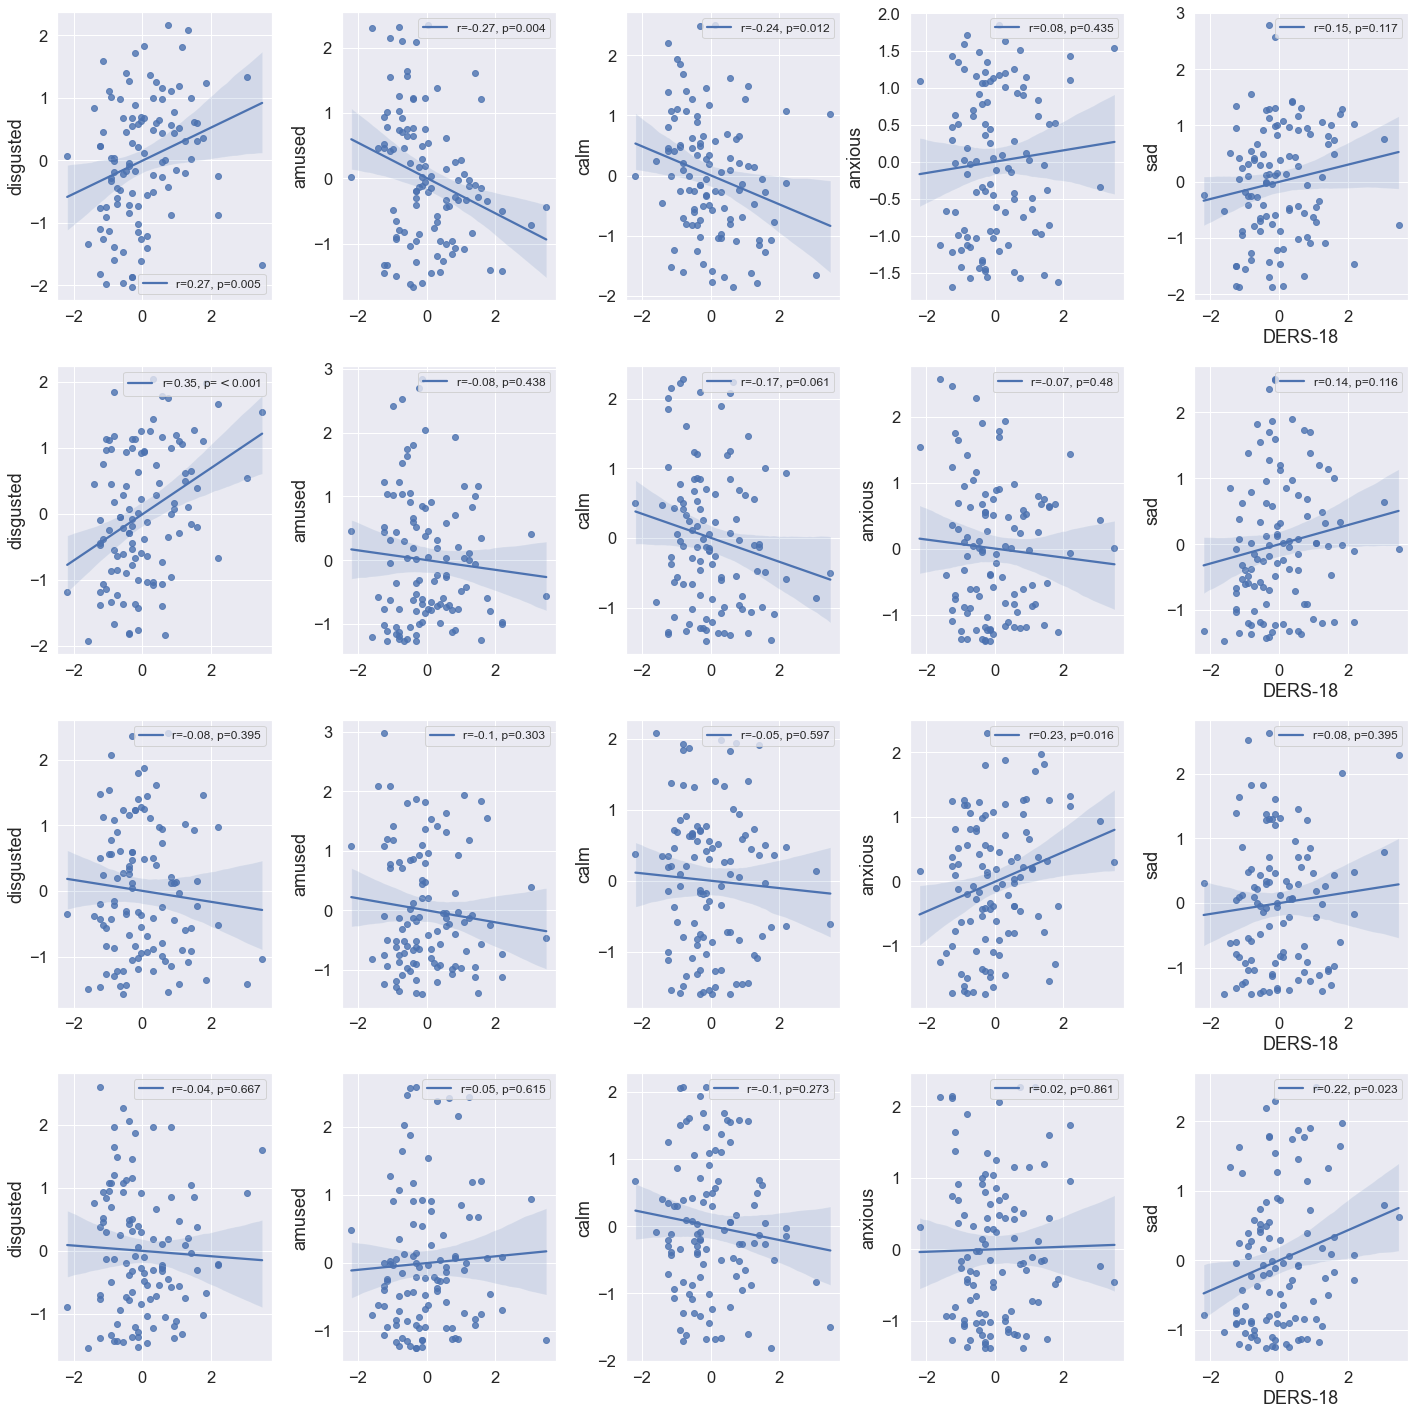

In [28]:
questionnaire_label = ['PHQ-9', 'GAD-7', 'DERS-18']
for r, q in enumerate(questionnaires):
    fig,axs= plt.subplots(len(timing), len(mood_categories), figsize=(20,20))
    grid = plt.GridSpec(len(timing), len(mood_categories))
    for m,t in enumerate(timing):
        c = [i for i in df_mood.columns if t in i]
        for n,cc in enumerate(c):
            slope = df_stats_all[r][(mood_categories[n],'coef')].loc[q + ' -> ' + t]
            p_value = df_stats_all[r][(mood_categories[n],'P>|z|')].loc[q + ' -> ' + t]
            b = sns.regplot(data = df_mood, x=q, y=cc, ax=axs[m,n], \
                            line_kws={'label': 'r=' + str(np.round(slope,2)) + ', p=' + str(p_value)})
            b.legend(prop={'size': 12})
            if n == len(timing): b.set(xlabel=questionnaire_label[r])
            else: b.set(xlabel='')
            b.set(ylabel=mood_categories[n])
#         create_subtitle(fig, grid[m, ::], list(timing.keys())[m])
plt.tight_layout()